# Star Wars Imperial Assault Odds Calculator

Provides utilities for simulating and analysing attacks of various sorts, including straight average damage and leftover surges as well as graphing capabilities.

## Imports and Infrastructure

In [30]:
import itertools
import collections
import unittest
import sys

# Hat-tip from http://ino.pm/blog/ipython-pygal/#.Vq2nVPkrKc1 by Ino de Bruijn for how to get pygal and Jupyter playing together.
from IPython.display import SVG
import pygal
# Can then use it like:
## bar_chart = pygal.Bar()                                            # Then create a bar graph object
## bar_chart.add('Fibonacci', [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55])  # Add some values
## bar_chart.render_to_file('fib.svg')
## SVG(bar_chart.render())


def run_test(case):
    """Run the given test case for text results."""
    suite = unittest.defaultTestLoader.loadTestsFromTestCase(case)
    unittest.TextTestRunner(verbosity=1,stream=sys.stderr).run(suite)

def odometer(base, digits):
    """Produce an iterator of all readings of an "odometer" in the given base that is digits long.
    
    For example, odometer(4, 2) produces the following values in this specific order:
    
    [(0,0), (0,1), (0,2), (0,3),
     (1,0), (1,1), (1,2), (1,3),
     (2,0), (2,1), (2,2), (2,3),
     (3,0), (3,1), (3,2), (3,3)]
    """
    return itertools.product(range(base),repeat=digits)

# itertools recipe from Python 3.1 documentation
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

class TestInfrastructure(unittest.TestCase):
    def test_odometer(self):
        self.assertEqual(list(odometer(4, 2)),
                         [(0,0), (0,1), (0,2), (0,3),
                          (1,0), (1,1), (1,2), (1,3),
                          (2,0), (2,1), (2,2), (2,3),
                          (3,0), (3,1), (3,2), (3,3)])
        self.assertEqual(list(odometer(6,1)), [(i,) for i in range(6)])
        
    def test_powerset(self):
        # Just one test, since powerset is straight from a well-tested recipe.
        self.assertEqual(list(powerset([1,2,3])), [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)])

run_test(TestInfrastructure)



..
----------------------------------------------------------------------
Ran 2 tests in 0.000s

OK


## Dice and Die Faces

A Face is a named collection (defined below) with an accuracy/range rating, a damage rating, a surge rating, a block rating, an evade rating, and a whiff/dodge rating. In practice, it's not meaningful for any face to have non-zero ratings on all of these. Instead, attack dice may have non-zero accuracy/damage/surge while defense dice may have non-zero block/evade/whiff.

A die is an array of 6 Faces.

This block also defines the core game dice: red (RED), blue (BLU), green (GRN), and yellow (YEL) attack dice and black (BLK) and white (WHT) defense dice.

In [31]:
Face = collections.namedtuple('Face', ['acc','dmg','srg','blk','evd','whf'])
BLANK_FACE = Face(0,0,0,0,0,0)

def atk_face(acc, dmg, srg):
    """Produce an attack die face with the given accuracy/range, damage, and surge."""
    return Face(acc, dmg, srg, 0, 0, 0)

def def_face(blk, evd, whf):
    """Produce a defense die face with the given block, evade, and whiff/dodge."""
    return Face(0, 0, 0, blk, evd, whf)

# Core game dice:
RED = [atk_face(0,1,0),atk_face(0,2,0),atk_face(0,2,0),atk_face(0,2,1),atk_face(0,3,0),atk_face(0,3,0)]
BLU = [atk_face(2,1,0),atk_face(2,0,1),atk_face(3,2,0),atk_face(3,1,1),atk_face(4,2,0),atk_face(5,1,0)]
GRN = [atk_face(1,0,1),atk_face(1,1,1),atk_face(1,2,0),atk_face(2,2,0),atk_face(2,1,1),atk_face(3,2,0)]
YEL = [atk_face(0,0,1),atk_face(0,1,2),atk_face(1,1,1),atk_face(1,2,0),atk_face(2,0,1),atk_face(2,1,0)]
BLK = [def_face(1,0,0),def_face(1,0,0),def_face(2,0,0),def_face(2,0,0),def_face(3,0,0),def_face(0,1,0)]
WHT = [def_face(0,0,0),def_face(1,0,0),def_face(0,1,0),def_face(1,1,0),def_face(1,1,0),def_face(0,0,1)]

def is_face(obj):
    """Is the object a die face?
    
    Works on any object."""
    # Feel free to try duck-typing here (or folded into elsewhere), but I'm keeping it simple for the time being!
    # MAY also want to check that, e.g., everything's an integer.
    return isinstance(obj, Face)

def is_atk_face(obj):
    """Is the object a valid face for an attack die?
    
    Works on any object."""
    return is_face(obj) and obj.blk == 0 and obj.evd == 0 and obj.whf == 0

def is_def_face(obj):
    """Is the object a valid face for a defense die?
    
    Works on any object."""
    return is_face(obj) and obj.acc == 0 and obj.dmg == 0 and obj.srg == 0

def make_cunning_die(die):
    """Produce a version of the given die appropriate for a figure with the "cunning" attribute.
    
    "Cunning" adds a block wherever the die has an evade."""
    return [face._replace(blk=(face.blk+face.evd)) for face in die]


class TestDieMethods(unittest.TestCase):
    def test_attack_creation(self):
        self.assertEqual(atk_face(1, 2, 3), Face(acc=1, dmg=2, srg=3, blk=0, evd=0, whf=0))

    def test_defense_creation(self):
        self.assertEqual(def_face(1, 2, 3), Face(acc=0, dmg=0, srg=0, blk=1, evd=2, whf=3))
        
    def test_type_pred(self):
        self.assertTrue(is_face(BLANK_FACE))
        self.assertTrue(is_face(Face(acc=1, dmg=2, srg=3, blk=4, evd=5, whf=6)))
        self.assertTrue(is_face(atk_face(1,2,3)))
        self.assertTrue(is_face(def_face(1,2,3)))
        self.assertFalse(is_face((1,2,3,4,5,6)))

        self.assertTrue(is_atk_face(BLANK_FACE))
        self.assertFalse(is_atk_face(Face(acc=1, dmg=2, srg=3, blk=4, evd=5, whf=6)))
        self.assertFalse(is_atk_face(Face(acc=1, dmg=2, srg=3, blk=4, evd=0, whf=0)))
        self.assertFalse(is_atk_face(Face(acc=1, dmg=2, srg=3, blk=0, evd=5, whf=0)))
        self.assertFalse(is_atk_face(Face(acc=1, dmg=2, srg=3, blk=0, evd=0, whf=6)))
        self.assertTrue(is_atk_face(Face(acc=1, dmg=2, srg=3, blk=0, evd=0, whf=0)))
        self.assertTrue(is_atk_face(atk_face(1,2,3)))
        self.assertFalse(is_atk_face(def_face(1,2,3)))
        self.assertFalse(is_atk_face((1,2,3,0,0,0)))
        
        self.assertTrue(is_def_face(BLANK_FACE))
        self.assertFalse(is_def_face(Face(acc=1, dmg=2, srg=3, blk=4, evd=5, whf=6)))
        self.assertFalse(is_def_face(Face(acc=1, dmg=0, srg=0, blk=4, evd=5, whf=6)))
        self.assertFalse(is_def_face(Face(acc=0, dmg=2, srg=0, blk=4, evd=5, whf=6)))
        self.assertFalse(is_def_face(Face(acc=0, dmg=0, srg=3, blk=4, evd=5, whf=6)))
        self.assertTrue(is_def_face(Face(acc=0, dmg=0, srg=0, blk=1, evd=2, whf=3)))
        self.assertTrue(is_def_face(def_face(1,2,3)))
        self.assertFalse(is_def_face(atk_face(1,2,3)))
        self.assertFalse(is_def_face((0,0,0,1,2,3)))
    
    def test_generic_creation(self):
        self.assertEqual(Face(acc=4, dmg=5, srg=6, blk=1, evd=2, whf=3), Face(4, 5, 6, 1, 2, 3))
    
    def test_make_cunning_die(self):
        mixed_die = [def_face(2,3,1),def_face(0,1,0),def_face(2,0,1),def_face(1,1,1),atk_face(1,2,3),BLANK_FACE]
        simple_die = [def_face(0,1,0)] * 6
        
        self.assertEqual(make_cunning_die(simple_die), [def_face(1,1,0)] * 6)
        self.assertEqual(make_cunning_die(mixed_die), 
                         [def_face(5,3,1),def_face(1,1,0),def_face(2,0,1),def_face(2,1,1),atk_face(1,2,3),BLANK_FACE])

run_test(TestDieMethods)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


### Modifiers

A Modifier is a surge-based alteration to a roll represented as a tuple of a cost in surges and a Face used to modify the result of a roll. A zero-cost modifier (like the E-Web Engineer's accuracy bonus) is "mandatory" and may be positive or negative (the latter generally contributed by the defender). A modifier with a positive cost requires that many surges to trigger and is optional. In theory, we might branch out to support more complex modifiers. In practice, those will probably be better handled by other means.

*However*, it's ill-defined how a surge-based modifier with a non-zero with a non-zero srg or evd modifier would behave, since one wouldn't be able to pay the cost for the surge-based modifier until after the number of surges was firmly established.

Further, since whiffs (dodges) are absolute, there's no clear reason to have a whf modifier.

Therefore, in the end, a modifier's Face has srg, evd, and whf all equal to zero. acc, dmg, and blk can all be non-zero.

Typical modifiers might increase or decrease accuracy/range, damage, or block. Note that "pierce" is really a decrease to block.

Calculations with modifiers will generally clamp to zero during processing of the modifiers (avoiding negatives). So, care should be taken to apply modifiers in a sensible order. Typically, the "attacker first and then defender" order demanded by SW:IA will handle his, but we may need to revisit this.

In [3]:
Modifier = collections.namedtuple('Modifier', ['cost','face'])
BLANK_MOD = Modifier(0,BLANK_FACE)

def is_modifier(obj):
    """Is the object a valid surge-based modifier?
    
    Works on any object."""
    # Feel free to switch to a duck typing solution.
    # I want to do more constrained typing and at least check that the
    # relatively complex face field is the type I want.
    return isinstance(obj, Modifier) and is_face(obj.face)

def is_mandatory_modifier(mod):
    """Given a modifier, determine whether it is mandatory (must be applied, i.e., cost 0)."""
    return mod.cost == 0
    
def make_mod(face, cost=0):
    """Make a modifier with the given face and surge cost (defaults to 0)."""
    return Modifier(cost, face)

def mod_acc(amt, cost=0):
    """Make an accuracy/range modifier with the given surge cost (defaults to 0)."""
    return make_mod(BLANK_FACE._replace(acc=amt), cost)

def mod_dmg(amt, cost=0):
    """Make a damage modifier with the given surge cost (defaults to 0)."""
    return make_mod(BLANK_FACE._replace(dmg=amt), cost)

def mod_blk(amt, cost=0):
    """Make a block modifier with the given surge cost (defaults to 0)."""
    return make_mod(BLANK_FACE._replace(blk=amt), cost)

def mod_prc(amt, cost=0):
    """Make a pierce modifier with the given surge cost (defaults to 0).
    
    A pierce modifier is a negative block modifier."""
    return mod_blk(-amt, cost) # Pierce is negative block

class TestModMethods(unittest.TestCase):
    def test_generic_creation(self):
        self.assertEqual(make_mod(Face(acc=1, dmg=2, srg=3, blk=4, evd=5, whf=6),2),
                        Modifier(2, Face(acc=1, dmg=2, srg=3, blk=4, evd=5, whf=6)))
        self.assertEqual(make_mod(Face(acc=9, dmg=8, srg=6, blk=1, evd=5, whf=3)), 
                         make_mod(Face(acc=9, dmg=8, srg=6, blk=1, evd=5, whf=3), 0))

    def test_dedicated_creation(self):
        self.assertEqual(mod_acc(3,2),
                        Modifier(2, Face(acc=3, dmg=0, srg=0, blk=0, evd=0, whf=0)))
        self.assertEqual(mod_acc(4), 
                        Modifier(0, Face(acc=4, dmg=0, srg=0, blk=0, evd=0, whf=0)))
        self.assertEqual(mod_dmg(5,3),
                        Modifier(3, Face(acc=0, dmg=5, srg=0, blk=0, evd=0, whf=0)))
        self.assertEqual(mod_dmg(6), 
                        Modifier(0, Face(acc=0, dmg=6, srg=0, blk=0, evd=0, whf=0)))
        self.assertEqual(mod_prc(7,4),
                        Modifier(4, Face(acc=0, dmg=0, srg=0, blk=-7, evd=0, whf=0)))
        self.assertEqual(mod_prc(8), 
                        Modifier(0, Face(acc=0, dmg=0, srg=0, blk=-8, evd=0, whf=0)))
        self.assertEqual(mod_blk(9,5),
                        Modifier(5, Face(acc=0, dmg=0, srg=0, blk=9, evd=0, whf=0)))
        self.assertEqual(mod_blk(10), 
                        Modifier(0, Face(acc=0, dmg=0, srg=0, blk=10, evd=0, whf=0)))

    def test_type_pred(self):
        self.assertTrue(is_modifier(BLANK_MOD))
        self.assertTrue(is_modifier(Modifier(1, Face(1,2,3,4,5,6))))
        self.assertTrue(is_modifier(mod_acc(3, 2)))
        self.assertFalse(is_modifier((1,Face(1,2,3,4,5,6))))
        self.assertFalse(is_modifier(Modifier(1,2)))

    def test_is_mandatory(self):
        self.assertTrue(is_mandatory_modifier(BLANK_MOD))
        self.assertTrue(is_mandatory_modifier(mod_acc(4)))
        self.assertTrue(is_mandatory_modifier(mod_acc(4,0)))
        self.assertFalse(is_mandatory_modifier(mod_acc(4,3)))
        self.assertTrue(is_mandatory_modifier(mod_blk(4)))
        self.assertTrue(is_mandatory_modifier(mod_blk(4,0)))
        self.assertFalse(is_mandatory_modifier(mod_blk(4,2)))
        self.assertFalse(is_mandatory_modifier(Modifier(1, Face(1,2,3,4,5,6))))
        self.assertTrue(is_mandatory_modifier(Modifier(0, Face(1,2,3,4,5,6))))


run_test(TestModMethods)

....
----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


## Summarizing Dice Rolls

A key element of simulating rolls is to produce all possible rolls given a set of dice. These functions together generate a map from a tuple of die face numbers (0 through 5, one number for each die in the roll) to the sum of the dice's face values. Thus, the value in each item is a "Face" but not necessarily one that could reasonably appear on any die (since it has both offensive and defensive values).

In [32]:
def sum_faces(faces):
    """Given an iterable of Faces, produce a single Face with the sum of all values in the individual faces."""
    
    def add_die_faces(face1, face2):
        return Face._make(x+y for x,y in zip(face1, face2))
    
    result = BLANK_FACE
    for face in faces:
        result = add_die_faces(result, face)
    return result

def gen_summed_faces_table(dice):
    """Generates a dictionary mapping from face #s for each of the 0 or more dice provided to the total "face" from the roll.
    
    In other words, this produces all possible rolls and, for each, adds up the results from each face rolled into a single total."""
    
    results = {}
    
    # Stop if there are no dice.
    if len(dice) == 0:
        return results
    
    # For each possible roll of the dice. (An odometer in base 6 because these are 6-sided dice with len(dice) "slots".)
    for index in odometer(6, len(dice)):
        # Sum the faces shown on each die and put it in the results.
        results[index] = sum_faces(die[face_num] for (die, face_num) in zip(dice, index))
    
    return results

class TestSummarizeRolls(unittest.TestCase):
    def test_sum_faces(self):
        self.assertEqual(sum_faces([]), BLANK_FACE)
        self.assertEqual(sum_faces([atk_face(1,2,3)]), atk_face(1,2,3))
        self.assertEqual(sum_faces([atk_face(1,2,3), atk_face(30,20,10)]), atk_face(31,22,13))
        self.assertEqual(sum_faces([atk_face(30,20,10), def_face(100,200,300), atk_face(1,2,3)]), 
                         Face(acc=31,dmg=22,srg=13,blk=100,evd=200,whf=300))
        
        
    def test_empty_array(self):
        self.assertEqual(gen_summed_faces_table([]), {})
    
    def test_one_die(self):
        self.assertEqual(gen_summed_faces_table([RED]), {
                (0,):atk_face(0,1,0),
                (1,):atk_face(0,2,0),
                (2,):atk_face(0,2,0),
                (3,):atk_face(0,2,1),
                (4,):atk_face(0,3,0),
                (5,):atk_face(0,3,0)
            })
    
    def test_two_dice(self):
        self.assertEqual(gen_summed_faces_table([RED,BLK]), {
              (0,0):Face(acc=0,dmg=1,srg=0,blk=1,evd=0,whf=0),
              (0,1):Face(acc=0,dmg=1,srg=0,blk=1,evd=0,whf=0),
              (0,2):Face(acc=0,dmg=1,srg=0,blk=2,evd=0,whf=0),
              (0,3):Face(acc=0,dmg=1,srg=0,blk=2,evd=0,whf=0),
              (0,4):Face(acc=0,dmg=1,srg=0,blk=3,evd=0,whf=0),
              (0,5):Face(acc=0,dmg=1,srg=0,blk=0,evd=1,whf=0),
              (1,0):Face(acc=0,dmg=2,srg=0,blk=1,evd=0,whf=0),
              (1,1):Face(acc=0,dmg=2,srg=0,blk=1,evd=0,whf=0),
              (1,2):Face(acc=0,dmg=2,srg=0,blk=2,evd=0,whf=0),
              (1,3):Face(acc=0,dmg=2,srg=0,blk=2,evd=0,whf=0),
              (1,4):Face(acc=0,dmg=2,srg=0,blk=3,evd=0,whf=0),
              (1,5):Face(acc=0,dmg=2,srg=0,blk=0,evd=1,whf=0),
              (2,0):Face(acc=0,dmg=2,srg=0,blk=1,evd=0,whf=0),
              (2,1):Face(acc=0,dmg=2,srg=0,blk=1,evd=0,whf=0),
              (2,2):Face(acc=0,dmg=2,srg=0,blk=2,evd=0,whf=0),
              (2,3):Face(acc=0,dmg=2,srg=0,blk=2,evd=0,whf=0),
              (2,4):Face(acc=0,dmg=2,srg=0,blk=3,evd=0,whf=0),
              (2,5):Face(acc=0,dmg=2,srg=0,blk=0,evd=1,whf=0),
              (3,0):Face(acc=0,dmg=2,srg=1,blk=1,evd=0,whf=0),
              (3,1):Face(acc=0,dmg=2,srg=1,blk=1,evd=0,whf=0),
              (3,2):Face(acc=0,dmg=2,srg=1,blk=2,evd=0,whf=0),
              (3,3):Face(acc=0,dmg=2,srg=1,blk=2,evd=0,whf=0),
              (3,4):Face(acc=0,dmg=2,srg=1,blk=3,evd=0,whf=0),
              (3,5):Face(acc=0,dmg=2,srg=1,blk=0,evd=1,whf=0),
              (4,0):Face(acc=0,dmg=3,srg=0,blk=1,evd=0,whf=0),
              (4,1):Face(acc=0,dmg=3,srg=0,blk=1,evd=0,whf=0),
              (4,2):Face(acc=0,dmg=3,srg=0,blk=2,evd=0,whf=0),
              (4,3):Face(acc=0,dmg=3,srg=0,blk=2,evd=0,whf=0),
              (4,4):Face(acc=0,dmg=3,srg=0,blk=3,evd=0,whf=0),
              (4,5):Face(acc=0,dmg=3,srg=0,blk=0,evd=1,whf=0),
              (5,0):Face(acc=0,dmg=3,srg=0,blk=1,evd=0,whf=0),
              (5,1):Face(acc=0,dmg=3,srg=0,blk=1,evd=0,whf=0),
              (5,2):Face(acc=0,dmg=3,srg=0,blk=2,evd=0,whf=0),
              (5,3):Face(acc=0,dmg=3,srg=0,blk=2,evd=0,whf=0),
              (5,4):Face(acc=0,dmg=3,srg=0,blk=3,evd=0,whf=0),
              (5,5):Face(acc=0,dmg=3,srg=0,blk=0,evd=1,whf=0)
            })
    
    def test_probe_more_dice(self):
        result = gen_summed_faces_table([BLU,GRN,GRN,BLK,WHT])
            
        # Try three interesting results:
        self.assertEqual(result[(3,5,4,5,3)], Face(acc=(3+3+2),dmg=(1+2+1),srg=(1+0+1),blk=(0+1),evd=(1+1),whf=0))
        self.assertEqual(result[(0,0,0,0,0)], Face(acc=(2+1+1),dmg=(1+0+0),srg=(0+1+1),blk=(1+0),evd=0,whf=0))
        self.assertEqual(result[(5,5,5,5,5)], Face(acc=(5+3+3),dmg=(1+2+2),srg=(0+0+0),blk=(0+0),evd=(1+0),whf=1))
            
        # And three random results:
        self.assertEqual(result[(3,4,5,1,5)], Face(acc=(3+2+3),dmg=(1+1+2),srg=(1+1+0),blk=1,evd=0,whf=1))
        self.assertEqual(result[(5,4,0,3,0)], Face(acc=(5+2+1),dmg=(1+1+0),srg=(0+1+1),blk=2,evd=0,whf=0))
        self.assertEqual(result[(4,3,3,0,3)], Face(acc=(4+2+2),dmg=(2+2+2),srg=(0+0+0),blk=2,evd=1,whf=0))

run_test(TestSummarizeRolls)    

.....
----------------------------------------------------------------------
Ran 5 tests in 0.172s

OK


## Outcomes

An Outcome is one of two things:

+ A simple outcome is a named tuple (see below) with a damage amount and a number of "leftover" surges. (Leftover surges were not used in producing the outcome and could not fruitfully be used.)
+ A complex outcome is a dictionary mapping tuples of face numbers to outcomes (either simple or complex). Within the context of a specific roll, there must be one face number per die rolled, and these face numbers indicate the actual roll. The outcome is then the outcome associated with that roll. Complex outcomes are *used* to represent outcomes involving rerolls. If a particular roll would lead to a reroll, the outcome associated with that roll will be a complex outcome encompassing all the possible reroll results and *their* outcomes. (Those, recursively, may also be rerolls, as in the case when both attacker and defender have reroll capabilities.)  

In [5]:
SimpleOutcome = collections.namedtuple('SimpleOutcome',['dmg','srg'])
BLANK_OUTCOME = SimpleOutcome(0,0)

def is_simple_outcome(obj):
    """Is the object a valid simple outcome?
    
    Works on any object."""
    # Feel free to switch to a duck typing solution.
    # I want to do more constrained typing. However,
    # I plan to treat anything that is NOT a simple outcome
    # as a complex outcome.
    
    # I had some bugs in which tuples of the right SIZE to be
    # SimpleOutcomes (but not SimpleOutcomes) slipped out where
    # SOs were expected. This commented code helps detect that.
    #
    # Should be unnecessary if the code is working correctly and
    # limits some possibly-correct behaviour.
    #pseudo_simple_outcome = False
    #try:
    #    (dmg, srg) = obj
    #    pseudo_simple_outcome = True
    #except:
    #    pass
    #if pseudo_simple_outcome:
    #    assert (not isinstance(obj, tuple)) or isinstance(obj, SimpleOutcome)

    return isinstance(obj, SimpleOutcome)

def compare_simple_outcomes_dmg_srg(o1, o2):
    """Produce a positive number if o1 is better than o2, negative if o2 is better than o1, 0 if tied.
    
    "Better" means larger damage or, if tied, larger leftover surge count."""
    assert(is_simple_outcome(o1))
    assert(is_simple_outcome(o2))
    if o1.dmg == o2.dmg:
        return o1.srg - o2.srg
    else:
        return o1.dmg - o2.dmg

class TestSOMethods(unittest.TestCase):
    def test_type_pred(self):
        self.assertTrue(is_simple_outcome(BLANK_OUTCOME))
        self.assertTrue(is_simple_outcome(SimpleOutcome(3,2)))
        self.assertFalse(is_simple_outcome(None))
        
        # Try a "complex outcome", a map from tuples of face numbers for a roll to outcomes. 
        self.assertFalse(is_simple_outcome(dict([((1,2,3),SimpleOutcome(dmg=2,srg=1))])))
        
    def test_comparison(self):
        self.assertGreater(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=2,srg=2)), 0)
        self.assertGreater(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=2,srg=1)), 0)
        self.assertGreater(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=1,srg=2), SimpleOutcome(dmg=0,srg=3)), 0)
        self.assertGreater(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=3,srg=1)), 0)

        self.assertEqual(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=3,srg=2)), 0)

        self.assertLess(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=4,srg=1)), 0)
        self.assertLess(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=1,srg=2), SimpleOutcome(dmg=2,srg=2)), 0)
        self.assertLess(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=1,srg=2), SimpleOutcome(dmg=4,srg=3)), 0)
        self.assertLess(compare_simple_outcomes_dmg_srg(SimpleOutcome(dmg=3,srg=2), SimpleOutcome(dmg=3,srg=3)), 0)

run_test(TestSOMethods)

# TODO: will also want a character type. Can then focus given a character or an array of dice. 
# Similarly can strip def dice. Can add attack and defense mods. Will also want a textual comment on "additional abilities".

..
----------------------------------------------------------------------
Ran 2 tests in 0.000s

OK


## Simulating Attacks

Here's where the actual simulation is done! I've chosen simulations to be exact rather than Monte Carlo, which means complex simulations (especially with rerolls) can take a while but do produce precise results.

Characters that get to choose their dice pools are also a bit of a problem and not yet handled. (On defense, this is no big deal, since there are only two dice. On offense, a bit trickier.) Fundamentally, this would just be multiple simulations, choosing the best (according to some metric, like average damage).

### No Reroll Outcomes

Ignoring rerolls, the key question is: given an attack and defense pool, a required range (0 for melee attacks, even those achieved using reach!), and a set of modifiers for both attacker and defender (only mandatory for the latter), what are the outcomes in terms of damage and "leftover" surges. In all cases, we choose to *maximize damage* and then (when damage is tied) *maximize leftover surges* when an option arises. This isn't clearly the best case all the time, but it's a pretty good yardstick!

### Note for play aids

`select_best_surge_set` would be helpful to a player aid or an AI.

In [33]:
def get_damage(target_range, raw_face, bonus_face=BLANK_FACE):
    """Given a raw die face result and an optional bonus die face result, produce the SimpleOutcome of the attack.
    
    Takes blocks and range into account."""
    damage = max(0, raw_face.dmg + bonus_face.dmg)
    blocks = max(0, raw_face.blk + bonus_face.blk)
    net_damage = max(0, damage - blocks)
    accuracy = max(0, raw_face.acc + bonus_face.acc)
    return net_damage if accuracy >= target_range else 0

def apply_surge_set(target_range, surge_set, current_face, surges):
    """Given the attack's range, a collection of surges (Modifiers), the current face, and the available surges, 
    produce the SimpleOutcome caused by the given surge set.
    
    PRE-CONDITION: surges >= the total cost of surge_set"""
    # Gather the bonuses provided by the surges.
    bonus_face = sum_faces(mod.face for mod in surge_set)
    assert(bonus_face.srg == 0 and bonus_face.evd == 0 and bonus_face.whf == 0)

    total_cost = sum(mod.cost for mod in surge_set)

    # Compute the result after surges
    return SimpleOutcome(dmg=get_damage(target_range, current_face, bonus_face), srg=surges - total_cost)
    
def select_best_surge_set(target_range, surge_sets, current_face, surges):
    """Given the attack's range, a collection of sets of surges (Modifiers), the current face, and the available surges,
    Produce a tuple of the surge set that causes the most damage, breaking ties by leftover surges and that set's SimpleOutcome."""
    best_set = []
    best_result = SimpleOutcome(dmg=get_damage(target_range, current_face), srg=surges)
    
    for surge_set in surge_sets:
        total_cost = sum(mod.cost for mod in surge_set)
        if total_cost <= surges:
            result = apply_surge_set(target_range, surge_set, current_face, surges)
            
            # Keep it only if it's an improvement.
            if compare_simple_outcomes_dmg_srg(result, best_result) > 0:
                best_result = result
                best_set = surge_set
    
    return (best_set, best_result)


def gen_per_roll_outcomes(attack_dice, defense_dice, target_range, surge_mods):
    """Generate a map of rolls (tuple of 1 face number per die) to (simple) outcomes (damage, surges).
    
    attack_dice: array of dice that the attacker rolls (may be empty)
    defense_dice: array of dice that the defender rolls (may be empty)
    target_range: number of spaces to the target (needed accuracy; use 0 for attacks not requiring accuracy)
    surge_mods: iterable of Modifiers; a modifier with a 0 cost is considered mandatory
    """

    # Consolidate the mandatory modifiers.
    mandatory_mod = sum_faces(face for (cost, face) in surge_mods if cost == 0)
    cost_mods = (mod for mod in surge_mods if mod.cost != 0)

    roll_results = {}

    # Prepare to iterate over all choices of other surges.
    # This is exponential in the number of surges.
    # In the general case, I strongly suspect the "best surge set" is NP-complete,
    # but since the range of total damage will likely be small, a DP solution would probably work quite well.
    surge_sets = list(powerset(cost_mods)) # if it's not stored, then we cannot run through it multiple times
    
    dice = attack_dice + defense_dice
    roll_table = gen_summed_faces_table(dice)
    
    # Review possible outcomes.
    for (face_numbers, face) in roll_table.items():
        # Produce the face after mandatory modifiers
        face = sum_faces((face, mandatory_mod))
        
        # Compute available surges after evades.
        surges = max(0, face.srg - face.evd)

        # Note: whiffs (dodges) are absolute. If that changes, just need to set base result
        # to (0, surges). Then, handle "bonus" whiffs in the surge sets.
        if face.whf > 0:
            roll_results[face_numbers] = SimpleOutcome(dmg=0, srg=surges)
            continue

        (best_set, best_result) = select_best_surge_set(target_range, surge_sets, face, surges)
        roll_results[face_numbers] = best_result
    
    return roll_results

class TestGenPerRollMethods(unittest.TestCase):
    def test_regression(self):
        # Whiffs were producing non-SimpleOutcomes.
        white_die_outcomes = gen_per_roll_outcomes([], [WHT], 0, [])
        for outcome in white_die_outcomes.values():
            self.assertTrue(is_simple_outcome(outcome))
    
    def test_get_damage(self):
        self.assertEqual(get_damage(1, Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0)), 20)
        self.assertEqual(get_damage(2, Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0)), 20)
        
        # Less than zero damage.
        self.assertEqual(get_damage(2, Face(acc=2, dmg=10, srg=3, blk=30, evd=1, whf=0)), 0)
        
        # Insufficient range.
        self.assertEqual(get_damage(3, Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0)), 0)
        
        # Basic bonus
        self.assertEqual(get_damage(1, Face(acc=6, dmg=5, srg=4, blk=3, evd=2, whf=0),
                                    Face(acc=60, dmg=50, srg=40, blk=30, evd=20, whf=0)), 
                         22)
        
        # Net negative block
        self.assertEqual(get_damage(1, Face(acc=6, dmg=5, srg=4, blk=3, evd=2, whf=0),
                                    Face(acc=60, dmg=50, srg=40, blk=-5, evd=20, whf=0)), 
                         55)
        
        # Net negative damage
        self.assertEqual(get_damage(1, Face(acc=6, dmg=5, srg=4, blk=3, evd=2, whf=0),
                                    Face(acc=60, dmg=-8, srg=40, blk=30, evd=20, whf=0)), 
                         0)
        
        # Accuracy adjustment: makes the hit
        self.assertEqual(get_damage(8, Face(acc=6, dmg=5, srg=4, blk=3, evd=2, whf=0),
                                    Face(acc=60, dmg=50, srg=40, blk=30, evd=20, whf=0)), 
                         22)
        
        # Accuracy adjustment: misses the hit
        self.assertEqual(get_damage(4, Face(acc=6, dmg=5, srg=4, blk=3, evd=2, whf=0),
                                    Face(acc=-3, dmg=50, srg=40, blk=30, evd=20, whf=0)), 
                         0)
        
    def test_apply_surge_set(self):
        self.assertEqual(apply_surge_set(4, [mod_acc(3,1),mod_dmg(2,2)], Face(acc=2, dmg=50, srg=13, blk=30, evd=3, whf=0), 10),
                         SimpleOutcome(dmg=22,srg=7))
        
        
    def test_zero_one_die(self):
        self.assertEqual(gen_per_roll_outcomes([], [], 0, []), {})
        self.assertEqual(gen_per_roll_outcomes([RED], [], 0, []), {
                (0,):SimpleOutcome(dmg=1,srg=0),
                (1,):SimpleOutcome(dmg=2,srg=0),
                (2,):SimpleOutcome(dmg=2,srg=0),
                (3,):SimpleOutcome(dmg=2,srg=1),
                (4,):SimpleOutcome(dmg=3,srg=0),
                (5,):SimpleOutcome(dmg=3,srg=0),
            })
        self.assertEqual(gen_per_roll_outcomes([YEL], [], 0, []), {
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=1,srg=2),
                (2,):SimpleOutcome(dmg=1,srg=1),
                (3,):SimpleOutcome(dmg=2,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=1,srg=0),
            })
        self.assertEqual(gen_per_roll_outcomes([], [WHT], 0, []), {
                (0,):SimpleOutcome(dmg=0,srg=0),
                (1,):SimpleOutcome(dmg=0,srg=0),
                (2,):SimpleOutcome(dmg=0,srg=0),
                (3,):SimpleOutcome(dmg=0,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=0),
                (5,):SimpleOutcome(dmg=0,srg=0),
            })
        
    def test_range(self):
        self.assertEqual(gen_per_roll_outcomes([RED], [], 1, []), {
                (0,):SimpleOutcome(dmg=0,srg=0),
                (1,):SimpleOutcome(dmg=0,srg=0),
                (2,):SimpleOutcome(dmg=0,srg=0),
                (3,):SimpleOutcome(dmg=0,srg=1),
                (4,):SimpleOutcome(dmg=0,srg=0),
                (5,):SimpleOutcome(dmg=0,srg=0),
            })
        self.assertEqual(gen_per_roll_outcomes([YEL], [], 1, []), {
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=0,srg=2),
                (2,):SimpleOutcome(dmg=1,srg=1),
                (3,):SimpleOutcome(dmg=2,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=1,srg=0),
            })
        self.assertEqual(gen_per_roll_outcomes([YEL], [], 2, []), {
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=0,srg=2),
                (2,):SimpleOutcome(dmg=0,srg=1),
                (3,):SimpleOutcome(dmg=0,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=1,srg=0),
            })
        self.assertEqual(gen_per_roll_outcomes([YEL], [], 3, []), {
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=0,srg=2),
                (2,):SimpleOutcome(dmg=0,srg=1),
                (3,):SimpleOutcome(dmg=0,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=0,srg=0),
            })
        two_dice_range = gen_per_roll_outcomes([YEL,YEL], [], 3, [])
        self.assertEqual(two_dice_range[(3,3)],SimpleOutcome(dmg=0,srg=0))
        self.assertEqual(two_dice_range[(4,3)],SimpleOutcome(dmg=2,srg=1))
        self.assertEqual(two_dice_range[(3,4)],SimpleOutcome(dmg=2,srg=1))
        self.assertEqual(two_dice_range[(5,5)],SimpleOutcome(dmg=2,srg=0))        
        
    def test_two_dice(self):
        self.assertEqual(gen_per_roll_outcomes([YEL], [WHT], 0, []), {
                (0,0):SimpleOutcome(dmg=0,srg=1),
                (0,1):SimpleOutcome(dmg=0,srg=1),
                (0,2):SimpleOutcome(dmg=0,srg=0),
                (0,3):SimpleOutcome(dmg=0,srg=0),
                (0,4):SimpleOutcome(dmg=0,srg=0),
                (0,5):SimpleOutcome(dmg=0,srg=1),
                (1,0):SimpleOutcome(dmg=1,srg=2),
                (1,1):SimpleOutcome(dmg=0,srg=2),
                (1,2):SimpleOutcome(dmg=1,srg=1),
                (1,3):SimpleOutcome(dmg=0,srg=1),
                (1,4):SimpleOutcome(dmg=0,srg=1),
                (1,5):SimpleOutcome(dmg=0,srg=2),
                (2,0):SimpleOutcome(dmg=1,srg=1),
                (2,1):SimpleOutcome(dmg=0,srg=1),
                (2,2):SimpleOutcome(dmg=1,srg=0),
                (2,3):SimpleOutcome(dmg=0,srg=0),
                (2,4):SimpleOutcome(dmg=0,srg=0),
                (2,5):SimpleOutcome(dmg=0,srg=1),
                (3,0):SimpleOutcome(dmg=2,srg=0),
                (3,1):SimpleOutcome(dmg=1,srg=0),
                (3,2):SimpleOutcome(dmg=2,srg=0),
                (3,3):SimpleOutcome(dmg=1,srg=0),
                (3,4):SimpleOutcome(dmg=1,srg=0),
                (3,5):SimpleOutcome(dmg=0,srg=0),
                (4,0):SimpleOutcome(dmg=0,srg=1),
                (4,1):SimpleOutcome(dmg=0,srg=1),
                (4,2):SimpleOutcome(dmg=0,srg=0),
                (4,3):SimpleOutcome(dmg=0,srg=0),
                (4,4):SimpleOutcome(dmg=0,srg=0),
                (4,5):SimpleOutcome(dmg=0,srg=1),
                (5,0):SimpleOutcome(dmg=1,srg=0),
                (5,1):SimpleOutcome(dmg=0,srg=0),
                (5,2):SimpleOutcome(dmg=1,srg=0),
                (5,3):SimpleOutcome(dmg=0,srg=0),
                (5,4):SimpleOutcome(dmg=0,srg=0),
                (5,5):SimpleOutcome(dmg=0,srg=0),
            })

    def test_mandatory_surges(self):
        self.assertEqual(gen_per_roll_outcomes([YEL],[],4,[mod_acc(3)]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=0,srg=2),
            (2,):SimpleOutcome(dmg=1,srg=1),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=0,srg=1),
            (5,):SimpleOutcome(dmg=1,srg=0),                    
            })
        self.assertEqual(gen_per_roll_outcomes([YEL],[],4,[mod_acc(3),mod_dmg(1)]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=0,srg=2),
            (2,):SimpleOutcome(dmg=2,srg=1),
            (3,):SimpleOutcome(dmg=3,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=1),
            (5,):SimpleOutcome(dmg=2,srg=0),                    
            })
        self.assertEqual(gen_per_roll_outcomes([YEL],[],4,[mod_acc(3),mod_dmg(1),mod_blk(2)]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=0,srg=2),
            (2,):SimpleOutcome(dmg=0,srg=1),
            (3,):SimpleOutcome(dmg=1,srg=0),
            (4,):SimpleOutcome(dmg=0,srg=1),
            (5,):SimpleOutcome(dmg=0,srg=0),                    
            })
        with_pierce_result = gen_per_roll_outcomes([YEL],[BLK],0,[mod_prc(1)])
        self.assertEqual(with_pierce_result[(3,3)], SimpleOutcome(dmg=1,srg=0))
        self.assertEqual(with_pierce_result[(3,5)], SimpleOutcome(dmg=2,srg=0))

        self.assertEqual(gen_per_roll_outcomes([YEL],[],4,[make_mod(Face(acc=3,dmg=1,srg=0,blk=0,evd=0,whf=0))]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=0,srg=2),
            (2,):SimpleOutcome(dmg=2,srg=1),
            (3,):SimpleOutcome(dmg=3,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=1),
            (5,):SimpleOutcome(dmg=2,srg=0),                    
            })

    def test_select_best_surge_set(self):
        # + cannot afford any surges
        self.assertEqual(select_best_surge_set(1, [[], [mod_dmg(1,3)]], Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ([], SimpleOutcome(dmg=20,srg=2)))

        # + no surge makes range
        self.assertEqual(select_best_surge_set(3, [[], [mod_dmg(1,3)]], Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ([], SimpleOutcome(dmg=0,srg=2)))

        # + simple damage surge
        self.assertEqual(select_best_surge_set(1, [[], [mod_dmg(1,1)]], Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ([mod_dmg(1,1)], SimpleOutcome(dmg=21,srg=1)))

        # + two damage surges available, pick the better
        self.assertEqual(select_best_surge_set(1, [[mod_dmg(2,1)], [mod_dmg(1,1)]], Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ([mod_dmg(2,1)], SimpleOutcome(dmg=22,srg=1)))

        # + two-cost damage surge and two one-cost, pick the better
        self.assertEqual(select_best_surge_set(1, powerset([mod_dmg(2,1), mod_dmg(4,2), mod_dmg(1,1)]), 
                                                   Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ((mod_dmg(4,2),), SimpleOutcome(dmg=24,srg=0)))
        self.assertEqual(select_best_surge_set(1, powerset([mod_dmg(2,1), mod_dmg(2,2), mod_dmg(1,1)]), 
                                                   Face(acc=2, dmg=50, srg=3, blk=30, evd=1, whf=0), 2),
                         ((mod_dmg(2,1),mod_dmg(1,1)), SimpleOutcome(dmg=23,srg=0)))

    def test_surge_based_mods(self):
        # + simple damage surge available
        self.assertEqual(gen_per_roll_outcomes([YEL],[],0,[mod_dmg(1,1)]), {
            (0,):SimpleOutcome(dmg=1,srg=0),
            (1,):SimpleOutcome(dmg=2,srg=1),
            (2,):SimpleOutcome(dmg=2,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),                    
            })

        # + simple damage surge available; don't use for range failures
        self.assertEqual(gen_per_roll_outcomes([YEL],[],1,[mod_dmg(1,1)]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=0,srg=2),
            (2,):SimpleOutcome(dmg=2,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),                    
            })

        # + two damage surges available, pick the better
        self.assertEqual(gen_per_roll_outcomes([YEL],[],0,[mod_dmg(1,1), mod_dmg(2,1)]), {
            (0,):SimpleOutcome(dmg=2,srg=0),
            (1,):SimpleOutcome(dmg=4,srg=0),
            (2,):SimpleOutcome(dmg=3,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=2,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),
            })

        # + two-cost damage surge and two one-cost, pick the better (and it's the 2-cost)
        self.assertEqual(gen_per_roll_outcomes([YEL],[],0,[mod_dmg(4,2), mod_dmg(1,1), mod_dmg(2,1)]), {
            (0,):SimpleOutcome(dmg=2,srg=0),
            (1,):SimpleOutcome(dmg=5,srg=0),
            (2,):SimpleOutcome(dmg=3,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=2,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),
            })

        # + two-cost damage surge and two one-cost, pick the better (and it's the two 1-cost)
        self.assertEqual(gen_per_roll_outcomes([YEL],[],0,[mod_dmg(2,2), mod_dmg(1,1), mod_dmg(2,1)]), {
            (0,):SimpleOutcome(dmg=2,srg=0),
            (1,):SimpleOutcome(dmg=4,srg=0),
            (2,):SimpleOutcome(dmg=3,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=2,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),
            })

        # + range is short, mandatory accuracy bonus covers it, damage surge available.
        self.assertEqual(gen_per_roll_outcomes([YEL],[],1,[mod_dmg(1,1), mod_acc(1)]), {
            (0,):SimpleOutcome(dmg=1,srg=0),
            (1,):SimpleOutcome(dmg=2,srg=1),
            (2,):SimpleOutcome(dmg=2,srg=0),
            (3,):SimpleOutcome(dmg=2,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),
            })

        # + range is short, accuracy surge covers it, tradeoff vs. damage surge.
        self.assertEqual(gen_per_roll_outcomes([YEL],[],2,[mod_dmg(1,1), mod_acc(2,1)]), {
            (0,):SimpleOutcome(dmg=0,srg=1),
            (1,):SimpleOutcome(dmg=2,srg=0),
            (2,):SimpleOutcome(dmg=1,srg=0),
            (3,):SimpleOutcome(dmg=0,srg=0),
            (4,):SimpleOutcome(dmg=1,srg=0),
            (5,):SimpleOutcome(dmg=1,srg=0),
            })

        # + pierce 2 vs. damage 1; pick the right one at each step
        #   ALSO tests evades and whiff
        self.assertEqual(gen_per_roll_outcomes([YEL], [make_cunning_die(WHT)], 0, [mod_prc(2,1), mod_dmg(1,1)]), {
                (0,0):SimpleOutcome(dmg=1,srg=0),
                (0,1):SimpleOutcome(dmg=0,srg=1),
                (0,2):SimpleOutcome(dmg=0,srg=0),
                (0,3):SimpleOutcome(dmg=0,srg=0),
                (0,4):SimpleOutcome(dmg=0,srg=0),
                (0,5):SimpleOutcome(dmg=0,srg=1),
                (1,0):SimpleOutcome(dmg=2,srg=1),
                (1,1):SimpleOutcome(dmg=2,srg=0),
                (1,2):SimpleOutcome(dmg=1,srg=0),
                (1,3):SimpleOutcome(dmg=1,srg=0),
                (1,4):SimpleOutcome(dmg=1,srg=0),
                (1,5):SimpleOutcome(dmg=0,srg=2),
                (2,0):SimpleOutcome(dmg=2,srg=0),
                (2,1):SimpleOutcome(dmg=1,srg=0),
                (2,2):SimpleOutcome(dmg=0,srg=0),
                (2,3):SimpleOutcome(dmg=0,srg=0),
                (2,4):SimpleOutcome(dmg=0,srg=0),
                (2,5):SimpleOutcome(dmg=0,srg=1),
                (3,0):SimpleOutcome(dmg=2,srg=0),
                (3,1):SimpleOutcome(dmg=1,srg=0),
                (3,2):SimpleOutcome(dmg=1,srg=0),
                (3,3):SimpleOutcome(dmg=0,srg=0),
                (3,4):SimpleOutcome(dmg=0,srg=0),
                (3,5):SimpleOutcome(dmg=0,srg=0),
                (4,0):SimpleOutcome(dmg=1,srg=0),
                (4,1):SimpleOutcome(dmg=0,srg=1),
                (4,2):SimpleOutcome(dmg=0,srg=0),
                (4,3):SimpleOutcome(dmg=0,srg=0),
                (4,4):SimpleOutcome(dmg=0,srg=0),
                (4,5):SimpleOutcome(dmg=0,srg=1),
                (5,0):SimpleOutcome(dmg=1,srg=0),
                (5,1):SimpleOutcome(dmg=0,srg=0),
                (5,2):SimpleOutcome(dmg=0,srg=0),
                (5,3):SimpleOutcome(dmg=0,srg=0),
                (5,4):SimpleOutcome(dmg=0,srg=0),
                (5,5):SimpleOutcome(dmg=0,srg=0),
            })

run_test(TestGenPerRollMethods)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.012s

OK


### Converting Roll Outcomes to Damage Distributions

Generally speaking, we don't actually want to know each roll's outcome. Instead, we want to know the distribution of results that can occur from an attack. This function discards the information about rolls and aggregates information about outcomes.

In [7]:
def outcomes_from_per_roll_outcomes(per_roll_outcomes):
    """Given a table of face numbers (rolls) to outcomes (simple or complex), generate a table of SimpleOutcome -> frequency.
    
    Frequencies are not probabilities; to get probabilities, divide by total frequency.
    (Any outcome not mapped from has frequency = 0.)
    
    Complex outcomes are given overall frequency one, which is then subdivided among their sub-outcomes."""
    
    results = {}
    for (faces, outcome) in per_roll_outcomes.items():
        if is_simple_outcome(outcome):
            sub_results = {outcome: 1}
        else:
            sub_results = probs_from_per_roll_outcomes(outcome)
        for (outcome, freq) in sub_results.items():
            results[outcome] = results.setdefault(outcome, 0) + freq
    
    return results

def probs_from_outcomes(outcomes):
    """Given a map of simple outcomes to frequencies, produce a map of outcomes to probabilities.
    
    That is, divide each frequency by the total count of frequencies."""
    freq = sum(outcomes.values())
    return dict((index, value/freq) for (index, value) in outcomes.items())

# Note: only tested indirectly through tests of the mutually recursive function outcomes_from_per_roll_outcomes.
def probs_from_per_roll_outcomes(per_roll_outcomes):
    """Given per-roll outcomes (map of face numbers to simple/complex outcomes), produce a map of outcomes to probabilities."""
    return probs_from_outcomes(outcomes_from_per_roll_outcomes(per_roll_outcomes))

def avg_outcome(outcome_probs):
    """Given a map of SimpleOutcomes to probabilities, compute a single average SimpleOutcome"""
    damage = 0
    surge = 0
    for (outcome, prob) in outcome_probs.items():
        damage += outcome.dmg * prob
        surge += outcome.srg * prob
    return SimpleOutcome(dmg=damage, srg=surge)

class TestOutcomesFromPerRollMethods(unittest.TestCase):
    def test_simple_cases(self):
        # Trivial empty case
        self.assertEqual(outcomes_from_per_roll_outcomes({}), {})
        
        # One roll, then its outcome happens once.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,):SimpleOutcome(dmg=3,srg=5),
                }), {
                SimpleOutcome(dmg=3,srg=5):1,
            })
        
        # Two possible rolls with the same outcome. That outcome happens twice.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,):SimpleOutcome(dmg=3,srg=5),
                    (8,):SimpleOutcome(dmg=3,srg=5),
                }), {
                SimpleOutcome(dmg=3,srg=5):2,
            })
        
        # Two possible rolls with diff outcomes. Each happens once.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,):SimpleOutcome(dmg=2,srg=1),
                    (8,):SimpleOutcome(dmg=3,srg=5),
                }), {
                SimpleOutcome(dmg=3,srg=5):1,
                SimpleOutcome(dmg=2,srg=1):1
            })
        
        # Three rolls, two have the same outcome; one outcome happens once, one twice
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,):SimpleOutcome(dmg=3,srg=5),
                    (1,):SimpleOutcome(dmg=2,srg=1),
                    (2,):SimpleOutcome(dmg=3,srg=5),
                }), {
                SimpleOutcome(dmg=3,srg=5):2,
                SimpleOutcome(dmg=2,srg=1):1
            })

    def test_probs_from_outcomes(self):
        self.assertEqual(probs_from_outcomes({
                    SimpleOutcome(dmg=1,srg=2):4,
                }), {
                    SimpleOutcome(dmg=1,srg=2):1,
            })
        self.assertEqual(probs_from_outcomes({
                    SimpleOutcome(dmg=1,srg=2):4,
                    SimpleOutcome(dmg=3,srg=4):2,
                    SimpleOutcome(dmg=5,srg=6):3,
                    SimpleOutcome(dmg=7,srg=8):1,
                }), {
                    SimpleOutcome(dmg=1,srg=2):0.4,
                    SimpleOutcome(dmg=3,srg=4):0.2,
                    SimpleOutcome(dmg=5,srg=6):0.3,
                    SimpleOutcome(dmg=7,srg=8):0.1,
            })
        
    def test_avg_outcome(self):
        # Floating point arithmetic problems make the straightforward 0.1357 and 0.2468 version fail :P
        # Assert almost equals does not handle tumples as I would like
        self.assertEqual(avg_outcome({
                    SimpleOutcome(dmg=1,srg=2):0.1,
                    SimpleOutcome(dmg=3,srg=4):0.01,
                    SimpleOutcome(dmg=5,srg=6):0.001,
                    SimpleOutcome(dmg=7,srg=8):0.0001,
            }), SimpleOutcome(dmg=(1*0.1+3*0.01+5*0.001+7*0.0001),
                              srg=(2*0.1+4*0.01+6*0.001+8*0.0001)))
    
    def test_with_complex(self):
        # Simplest non-trivial case: a single outcome, which is "complex" but has only a single sub-outcome.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{(1,1):SimpleOutcome(dmg=2,srg=3)},
                }), {
                SimpleOutcome(dmg=2,srg=3):1,
            })
        # Complex outcome has two sub-outcomes that differ.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{
                        (1,1):SimpleOutcome(dmg=2,srg=3),
                        (1,2):SimpleOutcome(dmg=5,srg=4),
                    },
                }), {
                SimpleOutcome(dmg=2,srg=3):(1/2),
                SimpleOutcome(dmg=5,srg=4):(1/2),
            })
        # Complex outcome has two sub-outcomes that match.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{
                        (1,1):SimpleOutcome(dmg=2,srg=3),
                        (1,2):SimpleOutcome(dmg=2,srg=3),
                    },
                }), {
                SimpleOutcome(dmg=2,srg=3):1,
            })
        # Complex outcome alongside simple outcome.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{
                        (1,1):SimpleOutcome(dmg=2,srg=3),
                        (1,2):SimpleOutcome(dmg=5,srg=4),
                    },
                    (0,1):SimpleOutcome(dmg=1,srg=2),
                }), {
                SimpleOutcome(dmg=1,srg=2):1,
                SimpleOutcome(dmg=2,srg=3):(1/2),
                SimpleOutcome(dmg=5,srg=4):(1/2),
            })
        # Complex outcome alongside simple outcome, shared results.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{
                        (1,1):SimpleOutcome(dmg=2,srg=3),
                        (1,2):SimpleOutcome(dmg=5,srg=4),
                    },
                    (0,1):SimpleOutcome(dmg=2,srg=3),
                }), {
                SimpleOutcome(dmg=2,srg=3):(1 + 1/2),
                SimpleOutcome(dmg=5,srg=4):(1/2),
            })
        # Nested complex outcome.
        self.assertEqual(outcomes_from_per_roll_outcomes({
                    (0,0):{
                        (1,1):{
                            (2,):SimpleOutcome(dmg=2,srg=3),
                            (3,):SimpleOutcome(dmg=4,srg=5),
                        },
                        (1,2):SimpleOutcome(dmg=4,srg=5),
                        (3,2):SimpleOutcome(dmg=4,srg=5),
                    },
                    (0,1):SimpleOutcome(dmg=6,srg=7),
                    (0,2):SimpleOutcome(dmg=8,srg=9),
                    (1,1):SimpleOutcome(dmg=10,srg=11),
                }), {
                SimpleOutcome(dmg=2,srg=3):(1/6),
                SimpleOutcome(dmg=4,srg=5):(5/6),
                SimpleOutcome(dmg=6,srg=7):1,
                SimpleOutcome(dmg=8,srg=9):1,
                SimpleOutcome(dmg=10,srg=11):1,
            })
        
    def test_per_roll_test_results(self):
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,):SimpleOutcome(dmg=1,srg=0),
                (1,):SimpleOutcome(dmg=2,srg=0),
                (2,):SimpleOutcome(dmg=2,srg=0),
                (3,):SimpleOutcome(dmg=2,srg=1),
                (4,):SimpleOutcome(dmg=3,srg=0),
                (5,):SimpleOutcome(dmg=3,srg=0),
            }), {
                SimpleOutcome(dmg=1,srg=0):1,
                SimpleOutcome(dmg=2,srg=0):2,
                SimpleOutcome(dmg=2,srg=1):1,
                SimpleOutcome(dmg=3,srg=0):2,
            })
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=1,srg=2),
                (2,):SimpleOutcome(dmg=1,srg=1),
                (3,):SimpleOutcome(dmg=2,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=1,srg=0),
            }), {
                SimpleOutcome(dmg=0,srg=1):2,
                SimpleOutcome(dmg=1,srg=0):1,
                SimpleOutcome(dmg=1,srg=1):1,
                SimpleOutcome(dmg=1,srg=2):1,
                SimpleOutcome(dmg=2,srg=0):1,
            })
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,):SimpleOutcome(dmg=0,srg=0),
                (1,):SimpleOutcome(dmg=0,srg=0),
                (2,):SimpleOutcome(dmg=0,srg=0),
                (3,):SimpleOutcome(dmg=0,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=0),
                (5,):SimpleOutcome(dmg=0,srg=0),
            }), {
                SimpleOutcome(dmg=0,srg=0):6,
            })
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,):SimpleOutcome(dmg=0,srg=0),
                (1,):SimpleOutcome(dmg=0,srg=0),
                (2,):SimpleOutcome(dmg=0,srg=0),
                (3,):SimpleOutcome(dmg=0,srg=1),
                (4,):SimpleOutcome(dmg=0,srg=0),
                (5,):SimpleOutcome(dmg=0,srg=0),
            }), {
                SimpleOutcome(dmg=0,srg=0):5,
                SimpleOutcome(dmg=0,srg=1):1,
            })
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,):SimpleOutcome(dmg=0,srg=1),
                (1,):SimpleOutcome(dmg=0,srg=2),
                (2,):SimpleOutcome(dmg=1,srg=1),
                (3,):SimpleOutcome(dmg=2,srg=0),
                (4,):SimpleOutcome(dmg=0,srg=1),
                (5,):SimpleOutcome(dmg=1,srg=0),
            }), {
                SimpleOutcome(dmg=0,srg=1):2,
                SimpleOutcome(dmg=0,srg=2):1,
                SimpleOutcome(dmg=1,srg=0):1,
                SimpleOutcome(dmg=1,srg=1):1,
                SimpleOutcome(dmg=2,srg=0):1,
            })
        # Skipped a few here..
        self.assertEqual(outcomes_from_per_roll_outcomes({
                (0,0):SimpleOutcome(dmg=0,srg=1),
                (0,1):SimpleOutcome(dmg=0,srg=1),
                (0,2):SimpleOutcome(dmg=0,srg=0),
                (0,3):SimpleOutcome(dmg=0,srg=0),
                (0,4):SimpleOutcome(dmg=0,srg=0),
                (0,5):SimpleOutcome(dmg=0,srg=1),
                (1,0):SimpleOutcome(dmg=1,srg=2),
                (1,1):SimpleOutcome(dmg=0,srg=2),
                (1,2):SimpleOutcome(dmg=1,srg=1),
                (1,3):SimpleOutcome(dmg=0,srg=1),
                (1,4):SimpleOutcome(dmg=0,srg=1),
                (1,5):SimpleOutcome(dmg=0,srg=2),
                (2,0):SimpleOutcome(dmg=1,srg=1),
                (2,1):SimpleOutcome(dmg=0,srg=1),
                (2,2):SimpleOutcome(dmg=1,srg=0),
                (2,3):SimpleOutcome(dmg=0,srg=0),
                (2,4):SimpleOutcome(dmg=0,srg=0),
                (2,5):SimpleOutcome(dmg=0,srg=1),
                (3,0):SimpleOutcome(dmg=2,srg=0),
                (3,1):SimpleOutcome(dmg=1,srg=0),
                (3,2):SimpleOutcome(dmg=2,srg=0),
                (3,3):SimpleOutcome(dmg=1,srg=0),
                (3,4):SimpleOutcome(dmg=1,srg=0),
                (3,5):SimpleOutcome(dmg=0,srg=0),
                (4,0):SimpleOutcome(dmg=0,srg=1),
                (4,1):SimpleOutcome(dmg=0,srg=1),
                (4,2):SimpleOutcome(dmg=0,srg=0),
                (4,3):SimpleOutcome(dmg=0,srg=0),
                (4,4):SimpleOutcome(dmg=0,srg=0),
                (4,5):SimpleOutcome(dmg=0,srg=1),
                (5,0):SimpleOutcome(dmg=1,srg=0),
                (5,1):SimpleOutcome(dmg=0,srg=0),
                (5,2):SimpleOutcome(dmg=1,srg=0),
                (5,3):SimpleOutcome(dmg=0,srg=0),
                (5,4):SimpleOutcome(dmg=0,srg=0),
                (5,5):SimpleOutcome(dmg=0,srg=0),
            }), {
                SimpleOutcome(dmg=0,srg=0):13,
                SimpleOutcome(dmg=0,srg=1):10,
                SimpleOutcome(dmg=0,srg=2):2,
                SimpleOutcome(dmg=1,srg=0):6,
                SimpleOutcome(dmg=1,srg=1):2,
                SimpleOutcome(dmg=1,srg=2):1,
                SimpleOutcome(dmg=2,srg=0):2,
            })
        # And skipped the rest..

run_test(TestOutcomesFromPerRollMethods)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


## Computing outcomes with rerolls

Once we have the outcomes for all possible rolls, computing outcomes with rerolls becomes a matter of finding the average outcome of the rolls this roll could transform into for each possible reroll plan (i.e., set of dice to reroll). Note that SW:IA disallows rerolling any one die more than once (thank goodness!). This is really the only place where we treat attack and defense dice separately.

This is also where complex outcomes come in. Once there's a possible reroll, a single roll outcome gets replaced with the tree (map) of outcomes that it can lead to on reroll.

### Note for play aids

`select_best_reroll_plan` would be helpful to a player aid or an AI.

In [37]:
def flatten_outcome(outcome):
    """Convert any outcome into a SimpleOutcome, averaging complex outcomes to simplify."""
    if is_simple_outcome(outcome):
        return outcome
    else:
        return avg_outcome(probs_from_per_roll_outcomes(outcome))

# Positive if o1 is better than o2 (by dmg, ties broken by srg), 0 if equivalent, negative otherwise.
def compare_outcomes_avg_dmg_srg(o1, o2):
    """Compare any two outcomes by flattinging them to simple outcomes and comparing damages, breaking ties with surges.
    
    Produces a negative number if o2 is better than o1, 0 for ties, and a positive number if o1 is better than o2."""
    flat_o1 = flatten_outcome(o1)
    flat_o2 = flatten_outcome(o2)
    return compare_simple_outcomes_dmg_srg(flat_o1, flat_o2)

def is_better_outcome_attacker(o1, o2):
    """Is o1 a better outcome for the attacker than o2 (more damage or, if tied, more surges)?"""
    return compare_outcomes_avg_dmg_srg(o1, o2) > 0
    
def is_better_outcome_defender(o1, o2):
    """Is o1 a better outcome for the defender than o2 (less damage or, if tied, fewer surges)?"""
    return compare_outcomes_avg_dmg_srg(o1, o2) < 0

# TODO: extract tests for select_best_reroll_plan from test for gen_reroll_outcomes below.
def select_best_reroll_plan(per_roll_outcomes, roll, reroll_plans, is_better_outcome):
    """Produce a tuple of the best possible reroll plan and its (often complex) outcome among the given reroll plans.
    
    per_roll_outcomes: a map of roll (tuples of face numbers) to outcomes without rerolls
    roll: array of face numbers rolled
    reroll_plans: iterable of reroll plans. a reroll plan is a list of (unique) indexes of faces in roll to reroll
    is_better_outcome: predicate that, given two outcomes, determines if the first is better than the second
    """
    def gen_all_rerolls(roll, reroll_plan):
        # Generator yielding the possible rerolls of roll according to reroll_plan (in lexicographic order)
        # ASSUMPTION: reroll_plan is in sorted order, 
        #             for all elts d of reroll_plan, d is a valid index into roll,
        #             no repeats in reroll_plan
        
        for reroll in odometer(6, len(reroll_plan)):
            result = list(roll)
            for (i,value) in zip(reroll_plan, reroll):
                result[i] = value
            yield tuple(result)
            
    best_plan = []
    best_outcome = per_roll_outcomes[roll]
        
    # For every reroll plan:
    for reroll_plan in reroll_plans:
        # Old version went through all rolls finding those that matched except fixed dice:
        #reroll_outcome = dict([(newroll, outcome) \
        #                       for (newroll, outcome) in per_roll_outcomes.items() \
        #                       if faces_match_except_reroll_plan(roll, newroll, reroll_plan)])
            
        # New version produces all possible rerolls with fixed dice held steady.
        reroll_outcome = dict((newroll,per_roll_outcomes[newroll])
                              for newroll in gen_all_rerolls(roll, reroll_plan))
        
        if is_better_outcome(reroll_outcome, best_outcome):
            best_outcome = reroll_outcome
            best_plan = reroll_plan
        
    return (best_plan, best_outcome)

def gen_reroll_outcomes(per_roll_outcomes, dice, active_dice, rerolls, is_better_outcome):
    """Given (simple!) outcomes per possible roll on the given dice, produce (possibly complex) outcomes 
    representing the optimal reroll plan according to the given outcome comparator. Only the indexes of dice
    contained in active_dice may be rerolled. At most rerolls dice may be rerolled.
    
    PRECONDITION: active_dice contains no duplicates and only legal indexes into dice.
    
    ASSUMPTION: All rolls are equiprobable. All dice are 6-sided. (Can actually avoid the latter assumption
    by finding rerolls as those rolls that match the current roll in all but the dice to be rerolled.)"""

    # Cap rerolls at all active_dice
    rerolls = min(len(active_dice), rerolls)
    active_dice = sorted(active_dice) # ensures sorted order of reroll plans below
    
    # Collect all possible sets of rerolls of 1, 2, ..., rerolls dice from the set of active_dice.
    # Each set is a list of the indices of the dice to reroll
    # Note: each individual reroll plan is guaranteed in sorted order b/c active_dice is in sorted order.
    reroll_plans = list(itertools.chain.from_iterable(itertools.combinations(active_dice, r) for r in range(1,rerolls+1)))
    
    best_outcomes = {}
    for roll in per_roll_outcomes.keys():
        # Not used now, but later, I'll want to be able to fetch the best reroll plan to advise people on rerolls.
        (best_plan, reroll_outcome) = select_best_reroll_plan(per_roll_outcomes, roll, reroll_plans, is_better_outcome)
        best_outcomes[roll] = reroll_outcome
    
    return best_outcomes

def gen_defender_reroll_outcomes(per_roll_outcomes, attack_dice, defense_dice, rerolls):
    return gen_reroll_outcomes(per_roll_outcomes,
                               attack_dice + defense_dice,
                               [(i + len(attack_dice)) for i in range(len(defense_dice))],
                               rerolls,
                               is_better_outcome_defender)

def gen_attacker_reroll_outcomes(per_roll_outcomes, attack_dice, defense_dice, rerolls):
    return gen_reroll_outcomes(per_roll_outcomes,
                               attack_dice + defense_dice,
                               range(len(attack_dice)),
                               rerolls,
                               is_better_outcome_attacker)


class TestOutcomesFromRerollMethods(unittest.TestCase):
    def test_flatten(self):
        self.assertEqual(flatten_outcome(SimpleOutcome(dmg=1,srg=2)), SimpleOutcome(dmg=1,srg=2))
        self.assertEqual(flatten_outcome({
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }), SimpleOutcome(dmg=561,srg=1221))
    
    def test_comparators(self):
        # Just cursory testing, since these are very simple extensions of already tested functionality.
        self.assertEqual(compare_outcomes_avg_dmg_srg({
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }, SimpleOutcome(dmg=561,srg=1221)), 0)
        self.assertLess(compare_outcomes_avg_dmg_srg({
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }, {(0,):SimpleOutcome(dmg=561,srg=2443),(1,):SimpleOutcome(dmg=561,srg=0)}), 0)
        self.assertGreater(compare_outcomes_avg_dmg_srg({
                    (0,):SimpleOutcome(dmg=561,srg=2443),
                    (1,):SimpleOutcome(dmg=561,srg=0)
                }, {
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }), 0)
        
        self.assertTrue(is_better_outcome_attacker({
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }, {(0,):SimpleOutcome(dmg=561,srg=2441),(1,):SimpleOutcome(dmg=561,srg=0)}))
        self.assertFalse(is_better_outcome_attacker(SimpleOutcome(dmg=10,srg=1),SimpleOutcome(dmg=11,srg=0)))
        
        self.assertFalse(is_better_outcome_defender({
                    (0,):SimpleOutcome(dmg=3,srg=600),
                    (1,):SimpleOutcome(dmg=30,srg=60),
                    (2,):{
                        (0,0):SimpleOutcome(dmg=300,srg=6),
                        (1,1):SimpleOutcome(dmg=3000,srg=6000),
                    },
                }, {(0,):SimpleOutcome(dmg=561,srg=2441),(1,):SimpleOutcome(dmg=561,srg=0)}))
        self.assertTrue(is_better_outcome_defender(SimpleOutcome(dmg=10,srg=1),SimpleOutcome(dmg=11,srg=0)))
        
    def test_gen_reroll_outcomes(self):
        # For testing, exploiting the fact that we don't actually USE the dice, just its length.
        simple_test_roll = {
            (0,):SimpleOutcome(dmg=1,srg=6),
            (1,):SimpleOutcome(dmg=2,srg=5),
            (2,):SimpleOutcome(dmg=3,srg=4),
            (3,):SimpleOutcome(dmg=4,srg=3),
            (4,):SimpleOutcome(dmg=5,srg=2),
            (5,):SimpleOutcome(dmg=6,srg=1),
        }
        
        # Simple reroll with attacker in mind.
        self.assertEqual(gen_reroll_outcomes(simple_test_roll, [RED], [0], 1, is_better_outcome_attacker),{
                (0,):simple_test_roll,
                (1,):simple_test_roll,
                (2,):simple_test_roll,
                (3,):SimpleOutcome(dmg=4,srg=3),
                (4,):SimpleOutcome(dmg=5,srg=2),
                (5,):SimpleOutcome(dmg=6,srg=1),
            })
        # Simple reroll with defender in mind.
        self.assertEqual(gen_reroll_outcomes(simple_test_roll, [RED], [0], 1, is_better_outcome_defender),{
                (0,):SimpleOutcome(dmg=1,srg=6),
                (1,):SimpleOutcome(dmg=2,srg=5),
                (2,):SimpleOutcome(dmg=3,srg=4),
                (3,):simple_test_roll,
                (4,):simple_test_roll,
                (5,):simple_test_roll,
            })
        
        # No reroll when reroll count is zero.
        self.assertEqual(gen_reroll_outcomes(simple_test_roll, [RED], [0], 0, is_better_outcome_defender),
                        simple_test_roll)

        two_dice_roll = {
            (0,0):SimpleOutcome(dmg=15,srg=1),
            (0,1):SimpleOutcome(dmg=25,srg=1),
            (0,2):SimpleOutcome(dmg=35,srg=1),
            (0,3):SimpleOutcome(dmg=45,srg=1),
            (0,4):SimpleOutcome(dmg=55,srg=1),
            (0,5):SimpleOutcome(dmg=65,srg=1),
            (1,0):SimpleOutcome(dmg=14,srg=1),
            (1,1):SimpleOutcome(dmg=24,srg=1),
            (1,2):SimpleOutcome(dmg=34,srg=1),
            (1,3):SimpleOutcome(dmg=44,srg=1),
            (1,4):SimpleOutcome(dmg=54,srg=1),
            (1,5):SimpleOutcome(dmg=64,srg=1),
            (2,0):SimpleOutcome(dmg=13,srg=1),
            (2,1):SimpleOutcome(dmg=23,srg=1),
            (2,2):SimpleOutcome(dmg=33,srg=1),
            (2,3):SimpleOutcome(dmg=43,srg=1),
            (2,4):SimpleOutcome(dmg=53,srg=1),
            (2,5):SimpleOutcome(dmg=63,srg=1),
            (3,0):SimpleOutcome(dmg=12,srg=1),
            (3,1):SimpleOutcome(dmg=22,srg=1),
            (3,2):SimpleOutcome(dmg=32,srg=1),
            (3,3):SimpleOutcome(dmg=42,srg=1),
            (3,4):SimpleOutcome(dmg=52,srg=1),
            (3,5):SimpleOutcome(dmg=62,srg=1),
            (4,0):SimpleOutcome(dmg=11,srg=1),
            (4,1):SimpleOutcome(dmg=21,srg=1),
            (4,2):SimpleOutcome(dmg=31,srg=1),
            (4,3):SimpleOutcome(dmg=41,srg=1),
            (4,4):SimpleOutcome(dmg=51,srg=1),
            (4,5):SimpleOutcome(dmg=61,srg=1),
            (5,0):SimpleOutcome(dmg=10,srg=1),
            (5,1):SimpleOutcome(dmg=20,srg=1),
            (5,2):SimpleOutcome(dmg=30,srg=1),
            (5,3):SimpleOutcome(dmg=40,srg=1),
            (5,4):SimpleOutcome(dmg=50,srg=1),
            (5,5):SimpleOutcome(dmg=60,srg=1),
        }

        # Rerolls only the die allowed (with two dice!).
        only_reroll_first_of_two = two_dice_roll.copy()
        for (i,j) in ((i,j) \
                      for (i,j) in two_dice_roll.keys() \
                      if i >= 3):
            reroll_dict = dict(((i2,j2),outcome)
                               for ((i2,j2),outcome) in two_dice_roll.items()
                               if j2 == j)
            only_reroll_first_of_two[(i,j)] = reroll_dict
        self.assertEqual(gen_reroll_outcomes(two_dice_roll, [RED,WHT], [0], 2, is_better_outcome_attacker),
                         only_reroll_first_of_two)
        only_reroll_second_of_two = two_dice_roll.copy()
        for (i,j) in ((i,j) \
                      for (i,j) in two_dice_roll.keys() \
                      if j < 3):
            reroll_dict = dict(((i2,j2),outcome)
                               for ((i2,j2),outcome) in two_dice_roll.items()
                               if i2 == i)
            only_reroll_second_of_two[(i,j)] = reroll_dict
        self.assertEqual(gen_reroll_outcomes(two_dice_roll, [RED,WHT], [1], 2, is_better_outcome_attacker),
                         only_reroll_second_of_two)
        
        # Chooses the better die to reroll.
        choose_better_of_two = two_dice_roll.copy()
        # The second die is always the better choice IF it should be rerolled.
        # So, record all first die rerolls and then write over with second die rerolls.
        for (i,j) in ((i,j) \
                      for (i,j) in two_dice_roll.keys() \
                      if i >= 3):
            reroll_dict = dict(((i2,j2),outcome)
                               for ((i2,j2),outcome) in two_dice_roll.items()
                               if j2 == j)
            choose_better_of_two[(i,j)] = reroll_dict
        for (i,j) in ((i,j) \
                      for (i,j) in two_dice_roll.keys() \
                      if j < 3):
            reroll_dict = dict(((i2,j2),outcome)
                               for ((i2,j2),outcome) in two_dice_roll.items()
                               if i2 == i)
            choose_better_of_two[(i,j)] = reroll_dict
        self.assertEqual(gen_reroll_outcomes(two_dice_roll, [RED,WHT], [0,1], 1, is_better_outcome_attacker),
                         choose_better_of_two)
        
        # Rerolls only the relevant die or dice when multiple rerolls allowed.
        choose_best_of_two = choose_better_of_two.copy()
        # Record all first die rerolls, then all second die rerolls, then all both rerolls.
        for (i,j) in ((i,j) \
                      for (i,j) in two_dice_roll.keys() \
                      if i >= 3 and j < 3):
            choose_best_of_two[(i,j)] = two_dice_roll
        self.assertEqual(gen_reroll_outcomes(two_dice_roll, [RED,WHT], [0,1], 2, is_better_outcome_attacker),
                         choose_best_of_two)
        
        # Three dice roll, but where rolling a 3 is bad. First die 3 is -900 damage; second is -90; third is -9
        simple_three_dice_roll_threes_worst = dict(zip(odometer(6,3), [SimpleOutcome(dmg=1000,srg=1)]*(6**3)))
        for (d1, d2) in odometer(6,2):
            simple_three_dice_roll_threes_worst[(3,d1,d2)] = SimpleOutcome(dmg=100,srg=1)
            simple_three_dice_roll_threes_worst[(d1,3,d2)] = SimpleOutcome(dmg=910,srg=1)
            simple_three_dice_roll_threes_worst[(d1,d2,3)] = SimpleOutcome(dmg=991,srg=1)
        for d1 in range(6):
            simple_three_dice_roll_threes_worst[(d1,3,3)] = SimpleOutcome(dmg=901,srg=1)
            simple_three_dice_roll_threes_worst[(3,d1,3)] = SimpleOutcome(dmg=91,srg=1)
            simple_three_dice_roll_threes_worst[(3,3,d1)] = SimpleOutcome(dmg=10,srg=1)
        simple_three_dice_roll_threes_worst[(3,3,3)] = SimpleOutcome(dmg=1,srg=1)

        # Can only reroll two of the dice (first and third) b/c the other is not active.
        two_of_three_active = simple_three_dice_roll_threes_worst.copy()
        
        # Reroll one of the first and third dice.
        for (d1,d2) in odometer(6,2):
            two_of_three_active[(3,d1,d2)] = dict(((i1,d1,d2),simple_three_dice_roll_threes_worst[(i1,d1,d2)])
                                                  for i1 in range(6))
            two_of_three_active[(d1,d2,3)] = dict(((d1,d2,i1),simple_three_dice_roll_threes_worst[(d1,d2,i1)])
                                                  for i1 in range(6))
        
        # Reroll both of the first and third dice.
        for d1 in range(6):
            two_of_three_active[(3,d1,3)] = dict(((i1,d1,i2),simple_three_dice_roll_threes_worst[(i1,d1,i2)])
                                                 for (i1,i2) in odometer(6,2))

        self.assertEqual(gen_reroll_outcomes(simple_three_dice_roll_threes_worst, 
                                             [RED,YEL,WHT], [0,2], 2, is_better_outcome_attacker),
                         two_of_three_active)
        
        # Can reroll two of three dice.
        two_of_three_reroll = simple_three_dice_roll_threes_worst.copy()
        
        # Reroll one die. Note that if any OTHER die is 3, that'll be overwritten on the next loop anyway.
        # Thus, no need to "favor" the 1st over 2nd or 2nd over 3rd.
        for (d1,d2) in odometer(6,2):
            two_of_three_reroll[(3,d1,d2)] = dict(((i1,d1,d2),simple_three_dice_roll_threes_worst[(i1,d1,d2)])
                                                  for i1 in range(6))
            two_of_three_reroll[(d1,3,d2)] = dict(((d1,i1,d2),simple_three_dice_roll_threes_worst[(d1,i1,d2)])
                                                  for i1 in range(6))
            two_of_three_reroll[(d1,d2,3)] = dict(((d1,d2,i1),simple_three_dice_roll_threes_worst[(d1,d2,i1)])
                                                  for i1 in range(6))
        
        # Reroll two dice. If ALL 3, favor rerolling first and second.
        for d1 in range(6):
            two_of_three_reroll[(3,3,d1)] = dict(((i1,i2,d1),simple_three_dice_roll_threes_worst[(i1,i2,d1)])
                                                 for (i1,i2) in odometer(6,2))
            if d1 != 3:
                two_of_three_reroll[(3,d1,3)] = dict(((i1,d1,i2),simple_three_dice_roll_threes_worst[(i1,d1,i2)])
                                                     for (i1,i2) in odometer(6,2))
                two_of_three_reroll[(d1,3,3)] = dict(((d1,i1,i2),simple_three_dice_roll_threes_worst[(d1,i1,i2)])
                                                     for (i1,i2) in odometer(6,2))

        self.assertEqual(gen_reroll_outcomes(simple_three_dice_roll_threes_worst, 
                                             [RED,YEL,WHT], [0,1,2], 2, is_better_outcome_attacker),
                         two_of_three_reroll)
        
        # Can reroll all three dice.
        # Just need to update two_of_three_reroll on (3,3,3).
        all_three_reroll = two_of_three_reroll.copy()
        all_three_reroll[(3,3,3)] = simple_three_dice_roll_threes_worst
        self.assertEqual(gen_reroll_outcomes(simple_three_dice_roll_threes_worst, 
                                             [RED,YEL,WHT], [0,1,2], 3, is_better_outcome_attacker),
                         all_three_reroll)
                
    def test_gen_defender_reroll_outcomes(self):
        # EXPLOITING the fact that we don't actually use the IDENTITY of dice in reroll gen.
        simple_test_roll = {
            (0,):SimpleOutcome(dmg=1,srg=6),
            (1,):SimpleOutcome(dmg=2,srg=5),
            (2,):SimpleOutcome(dmg=3,srg=4),
            (3,):SimpleOutcome(dmg=4,srg=3),
            (4,):SimpleOutcome(dmg=5,srg=2),
            (5,):SimpleOutcome(dmg=6,srg=1),
        }

        # VERY simple testing.
        # Lightly checking that: which dice to reroll is handled correctly, the number of rerolls is passed
        # through, and the right comparator is called.
        self.assertEqual(gen_defender_reroll_outcomes(simple_test_roll, [RED], [], 1),simple_test_roll)
        self.assertEqual(gen_defender_reroll_outcomes(simple_test_roll, [], [RED], 0),simple_test_roll)
        self.assertEqual(gen_defender_reroll_outcomes(simple_test_roll, [], [RED], 1),{
                (0,):SimpleOutcome(dmg=1,srg=6),
                (1,):SimpleOutcome(dmg=2,srg=5),
                (2,):SimpleOutcome(dmg=3,srg=4),
                (3,):simple_test_roll,
                (4,):simple_test_roll,
                (5,):simple_test_roll,
            })
    
    def test_gen_attacker_reroll_outcomes(self):
        # EXPLOITING the fact that we don't actually use the IDENTITY of dice in reroll gen.
        simple_test_roll = {
            (0,):SimpleOutcome(dmg=1,srg=6),
            (1,):SimpleOutcome(dmg=2,srg=5),
            (2,):SimpleOutcome(dmg=3,srg=4),
            (3,):SimpleOutcome(dmg=4,srg=3),
            (4,):SimpleOutcome(dmg=5,srg=2),
            (5,):SimpleOutcome(dmg=6,srg=1),
        }

        # VERY simple testing.
        # Lightly checking that: which dice to reroll is handled correctly, the number of rerolls is passed
        # through, and the right comparator is called.
        self.assertEqual(gen_attacker_reroll_outcomes(simple_test_roll, [], [RED], 1),simple_test_roll)
        self.assertEqual(gen_attacker_reroll_outcomes(simple_test_roll, [RED], [], 0),simple_test_roll)
        self.assertEqual(gen_attacker_reroll_outcomes(simple_test_roll, [RED], [], 1),{
                (0,):simple_test_roll,
                (1,):simple_test_roll,
                (2,):simple_test_roll,
                (3,):SimpleOutcome(dmg=4,srg=3),
                (4,):SimpleOutcome(dmg=5,srg=2),
                (5,):SimpleOutcome(dmg=6,srg=1),
            })


run_test(TestOutcomesFromRerollMethods)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.480s

OK


## Overall Attack Summarization and Graphing

Here are the core utilities for simulating and summarizing an attack and visualizing its results.

In [9]:
# TODO: some simple testing to ensure this integrates existing code correctly.
def gen_overall_outcomes(attack_dice, defense_dice, target_range, surge_mods, attack_rerolls, defense_rerolls):
    """Generate the set of simple outcomes mapped to their probabilities for the given attack.
    
    Takes attacker and defender dice (arrays), the range to the target (non-negative integer),
    both attacker and defender surge modifications (array of Modifier), and the number of attacker
    and defender dice allowed to be rerolled (non-negative integers)."""
    
    # The straight-up roll with surges.
    per_roll = gen_per_roll_outcomes(attack_dice, defense_dice, target_range, surge_mods)
    
    # Allow rerolls for the attacker and defender.
    # TODO: some abilities allow the attacker to reroll defender dice (and maybe vice versa).
    # Would need some adjustments here to allow that!
    
    if attack_rerolls > 0:
        per_roll = gen_attacker_reroll_outcomes(per_roll, attack_dice, defense_dice, attack_rerolls)
    if defense_rerolls > 0:
        per_roll = gen_defender_reroll_outcomes(per_roll, attack_dice, defense_dice, defense_rerolls)
    return probs_from_per_roll_outcomes(per_roll)

# TODO: document and test.
def gen_vs(attacker, defender, rng = 0, atk_rerolls = 0, def_rerolls = 0):
    return gen_overall_outcomes(attacker[0], defender[1], rng, attacker[2] + defender[3], atk_rerolls, def_rerolls)

# TODO: document
def render_vs(attacker, defender, rng, atk_rerolls, def_rerolls, title, max_dmg = None):
    outcomes = gen_vs(attacker, defender, rng, atk_rerolls, def_rerolls)
    if max_dmg is None:
        max_dmg = max(dmg for (dmg, srg) in outcomes)
    max_srg = max(srg for (dmg, srg) in outcomes)
    outcome = avg_outcome(outcomes)
    line_chart = pygal.StackedLine(fill=True)
    line_chart.title = title
    line_chart.x_labels = map(str, range(max_dmg + 1))
    #line_chart.y_labels = map(str, map(lambda x: x / 10, range(0, 11, 1)))
    line_chart.range = (0, 1)
    for srg in reversed(range(max_srg + 1)):
        line_chart.add('Surge: ' + str(srg), [outcomes.get(SimpleOutcome(dmg=dmg, srg=srg)) for dmg in range(max_dmg + 1)])
    print("Average dmg, srg: %s, %s" % (outcome.dmg, outcome.srg))
    return SVG(line_chart.render())

def render_range(attacker, defender, range_range, atk_rerolls, def_rerolls, title):
    ranges = list(range_range)
    dmg_results = []
    srg_results = []
    for rng in ranges:
        outcomes = gen_vs(attacker, defender, rng, atk_rerolls, def_rerolls)
        outcome = avg_outcome(outcomes)
        dmg_results.append(outcome.dmg)
        srg_results.append(outcome.srg)
    line_chart = pygal.Line(fill=True)
    line_chart.title = title
    line_chart.x_labels = map(str, ranges)
    line_chart.add('Damage', dmg_results)
    line_chart.add('Surge', srg_results)
    return SVG(line_chart.render())

def render_comparison_vs(melee_attackers, reach_attackers, ranged_attackers, defender, range_range):
    # Each attacker is a tuple (name, fighter tuple, rerolls).
    # The defender is the same, but its name is used for the chart title.
    # range_range is assumed to begin with 1 and 2 (and to have length >= 2); regardless, 
    # melee attackers are marked on the first and reach on the first and second ticks of the x axis
    (def_name, def_def, def_rerolls) = defender
    ranges = list(range_range)
    line_chart = pygal.Line()
    line_chart.title = "Damage vs. %s" % def_name
    line_chart.x_labels = map(str, ranges)
    for (name, attacker, rerolls) in melee_attackers:
        outcomes = gen_vs(attacker, def_def, 0, rerolls, def_rerolls)
        dmg = avg_outcome(outcomes).dmg
        line_chart.add(name, [dmg] + [None] * (len(ranges) - 1))
    for (name, attacker, rerolls) in reach_attackers:
        outcomes = gen_vs(attacker, def_def, 0, rerolls, def_rerolls)
        dmg = avg_outcome(outcomes).dmg
        line_chart.add(name, [dmg, dmg] + [None] * (len(ranges) - 2))
    for (name, attacker, rerolls) in ranged_attackers:
        dmg_results = []
        for rng in ranges:
            outcomes = gen_vs(attacker, def_def, rng, rerolls, def_rerolls)
            dmg = avg_outcome(outcomes).dmg
            dmg_results.append(dmg)
        line_chart.add(name, dmg_results)
    return SVG(line_chart.render())

## Constants

Various useful game constants, including several characters. Note that the particular structure used for characters here is probably not great for rebel heroes. Heroes should have separate weapon items rather than (only) built-in dice and modifiers.

The dice section above also defines the key game dice constants (i.e., the red, blue, yellow, and other dice).

In [10]:
FOCUS_DICE = [GRN]

GAARKHAN_ATK_DICE = [RED, YEL]
GAARKHAN_DEF_DICE = [BLK]
GAARKHAN_ATK_MODS = [mod_prc(1, 1)]
GAARKHAN_DEF_MODS = []
GAARKHAN = (GAARKHAN_ATK_DICE, GAARKHAN_DEF_DICE, GAARKHAN_ATK_MODS, GAARKHAN_DEF_MODS)

FENN_ATK_DICE = [BLU, GRN]
FENN_DEF_DICE = [BLK]
FENN_ATK_MODS = [mod_dmg(1, 1), mod_acc(1, 1)]
FENN_DEF_MODS = []
FENN = (FENN_ATK_DICE, FENN_DEF_DICE, FENN_ATK_MODS, FENN_DEF_MODS)

DIALA_ATK_DICE = [BLU, GRN]
DIALA_DEF_DICE = [WHT]
DIALA_ATK_MODS = [mod_dmg(1, 1)]
DIALA_DEF_MODS = []
DIALA = (DIALA_ATK_DICE, DIALA_DEF_DICE, DIALA_ATK_MODS, DIALA_DEF_MODS)
# Diala also has a defensive reroll ability and offensive eliminate die ability.

DIALA_HAFT = (DIALA_ATK_DICE, DIALA_DEF_DICE, DIALA_ATK_MODS + [mod_prc(1)], DIALA_DEF_MODS)

JYN_ATK_DICE = [GRN, GRN]
JYN_DEF_DICE = [WHT]
JYN_ATK_MODS = [mod_dmg(1, 1), mod_acc(1, 1)]
JYN_DEF_MODS = []
JYN = (JYN_ATK_DICE, JYN_DEF_DICE, JYN_ATK_MODS, JYN_DEF_MODS)

JYN_W_DL_44 = ([BLU,YEL],JYN_DEF_DICE,[mod_dmg(2,1),make_mod(Face(acc=2,dmg=1,srg=0,blk=0,evd=0,whf=0),1)],JYN_DEF_MODS)

EWB_ATK_DICE = [BLU, RED, YEL]
EWB_DEF_DICE = [BLK]
EWB_ATK_MODS = [mod_dmg(1,1), mod_acc(3)]
EWB_DEF_MODS = []
EWB = (EWB_ATK_DICE, EWB_DEF_DICE, EWB_ATK_MODS, EWB_DEF_MODS)

NEX_ATK_DICE = [RED, GRN]
NEX_DEF_DICE = [make_cunning_die(WHT)]
NEX_ATK_MODS = [mod_prc(2,1)]
NEX_DEF_MODS = []
NEX = (NEX_ATK_DICE, NEX_DEF_DICE, NEX_ATK_MODS, NEX_DEF_MODS)

OFC_ATK_DICE = [BLU, YEL]
OFC_DEF_DICE = [WHT]
OFC_ATK_MODS = [mod_dmg(1,1), mod_acc(2,1)]
OFC_DEF_MODS = []
OFC = (OFC_ATK_DICE, OFC_DEF_DICE, OFC_ATK_MODS, OFC_DEF_MODS)
# Defensive reroll when adjacent to a friendly figure (cower).

EPB_ATK_DICE = [BLU, YEL, YEL]
EPB_DEF_DICE = [BLK]
EPB_ATK_MODS = [mod_dmg(2,1), mod_prc(2,1)]
EPB_DEF_MODS = []
EPB = (EPB_ATK_DICE, EPB_DEF_DICE, EPB_ATK_MODS, EPB_DEF_MODS)
# Attack reroll (targeting computer).

TRP_ATK_DICE = [BLU, YEL, YEL]
TRP_DEF_DICE = [BLK]
TRP_ATK_MODS = [mod_dmg(1,1), mod_acc(2,1)]
TRP_DEF_MODS = []
TRP = (TRP_ATK_DICE, TRP_DEF_DICE, TRP_ATK_MODS, TRP_DEF_MODS)
# Attack reroll (neighboring trooper).

## Miscellaneous Utilities

Various useful functions.

Much of this should eventually be subsumed in a structured way to manage characters, but until that happens, it just sits here!

In [11]:
def focus_dice(dice):
    return dice + FOCUS_DICE

def focus_char(char):
    (atk_dice, def_dice, atk_mods, def_mods) = char
    return (focus_dice(atk_dice), def_dice, atk_mods, def_mods)

def strip_def_die_dice(dice):
    return dice[1:]

def strip_def_die_char(char):
    (atk_dice, def_dice, atk_mods, def_mods) = char
    return (atk_dice, strip_def_die_dice(def_dice), atk_mods, def_mods)

# Output/Play Area

Nothing from here on is defining new functionality. It's simply using what's above to analyse game situations.

In [12]:
G_vs_ENG = gen_per_roll_outcomes(GAARKHAN_ATK_DICE, EWB_DEF_DICE, 0, EWB_DEF_MODS + GAARKHAN_ATK_MODS)

G_vs_ENG_probs = probs_from_outcomes(outcomes_from_per_roll_outcomes(G_vs_ENG))
(G_vs_ENG_probs, outcomes_from_per_roll_outcomes(G_vs_ENG))

({SimpleOutcome(dmg=0, srg=0): 0.027777777777777776,
  SimpleOutcome(dmg=0, srg=1): 0.05092592592592592,
  SimpleOutcome(dmg=0, srg=2): 0.013888888888888888,
  SimpleOutcome(dmg=1, srg=0): 0.16203703703703703,
  SimpleOutcome(dmg=1, srg=1): 0.041666666666666664,
  SimpleOutcome(dmg=1, srg=2): 0.004629629629629629,
  SimpleOutcome(dmg=2, srg=0): 0.22685185185185186,
  SimpleOutcome(dmg=2, srg=1): 0.0787037037037037,
  SimpleOutcome(dmg=2, srg=2): 0.009259259259259259,
  SimpleOutcome(dmg=3, srg=0): 0.19444444444444445,
  SimpleOutcome(dmg=3, srg=1): 0.06018518518518518,
  SimpleOutcome(dmg=3, srg=2): 0.013888888888888888,
  SimpleOutcome(dmg=4, srg=0): 0.0787037037037037,
  SimpleOutcome(dmg=4, srg=1): 0.027777777777777776,
  SimpleOutcome(dmg=5, srg=0): 0.009259259259259259},
 {SimpleOutcome(dmg=0, srg=0): 6,
  SimpleOutcome(dmg=0, srg=1): 11,
  SimpleOutcome(dmg=0, srg=2): 3,
  SimpleOutcome(dmg=1, srg=0): 35,
  SimpleOutcome(dmg=1, srg=1): 9,
  SimpleOutcome(dmg=1, srg=2): 1,
  Simpl

In [13]:
(G_vs_ENG_probs, avg_outcome(G_vs_ENG_probs).dmg, avg_outcome(G_vs_ENG_probs).srg)

({SimpleOutcome(dmg=0, srg=0): 0.027777777777777776,
  SimpleOutcome(dmg=0, srg=1): 0.05092592592592592,
  SimpleOutcome(dmg=0, srg=2): 0.013888888888888888,
  SimpleOutcome(dmg=1, srg=0): 0.16203703703703703,
  SimpleOutcome(dmg=1, srg=1): 0.041666666666666664,
  SimpleOutcome(dmg=1, srg=2): 0.004629629629629629,
  SimpleOutcome(dmg=2, srg=0): 0.22685185185185186,
  SimpleOutcome(dmg=2, srg=1): 0.0787037037037037,
  SimpleOutcome(dmg=2, srg=2): 0.009259259259259259,
  SimpleOutcome(dmg=3, srg=0): 0.19444444444444445,
  SimpleOutcome(dmg=3, srg=1): 0.06018518518518518,
  SimpleOutcome(dmg=3, srg=2): 0.013888888888888888,
  SimpleOutcome(dmg=4, srg=0): 0.0787037037037037,
  SimpleOutcome(dmg=4, srg=1): 0.027777777777777776,
  SimpleOutcome(dmg=5, srg=0): 0.009259259259259259},
 2.115740740740741,
 0.34259259259259267)

In [14]:
reroll_outcomes = gen_reroll_outcomes(G_vs_ENG, GAARKHAN_ATK_DICE + EWB_DEF_DICE, [0,1], 1, is_better_outcome_attacker)

reroll_outcomes

{(0, 0, 0): {(0, 0, 0): SimpleOutcome(dmg=1, srg=0),
  (1, 0, 0): SimpleOutcome(dmg=2, srg=0),
  (2, 0, 0): SimpleOutcome(dmg=2, srg=0),
  (3, 0, 0): SimpleOutcome(dmg=2, srg=1),
  (4, 0, 0): SimpleOutcome(dmg=3, srg=0),
  (5, 0, 0): SimpleOutcome(dmg=3, srg=0)},
 (0, 0, 1): {(0, 0, 1): SimpleOutcome(dmg=1, srg=0),
  (1, 0, 1): SimpleOutcome(dmg=2, srg=0),
  (2, 0, 1): SimpleOutcome(dmg=2, srg=0),
  (3, 0, 1): SimpleOutcome(dmg=2, srg=1),
  (4, 0, 1): SimpleOutcome(dmg=3, srg=0),
  (5, 0, 1): SimpleOutcome(dmg=3, srg=0)},
 (0, 0, 2): {(0, 0, 2): SimpleOutcome(dmg=0, srg=1),
  (1, 0, 2): SimpleOutcome(dmg=1, srg=0),
  (2, 0, 2): SimpleOutcome(dmg=1, srg=0),
  (3, 0, 2): SimpleOutcome(dmg=1, srg=1),
  (4, 0, 2): SimpleOutcome(dmg=2, srg=0),
  (5, 0, 2): SimpleOutcome(dmg=2, srg=0)},
 (0, 0, 3): {(0, 0, 3): SimpleOutcome(dmg=0, srg=1),
  (1, 0, 3): SimpleOutcome(dmg=1, srg=0),
  (2, 0, 3): SimpleOutcome(dmg=1, srg=0),
  (3, 0, 3): SimpleOutcome(dmg=1, srg=1),
  (4, 0, 3): SimpleOutcome(dm

In [15]:
sample_outcomes = gen_overall_outcomes(GAARKHAN_ATK_DICE, EWB_DEF_DICE, 0, GAARKHAN_ATK_MODS + EWB_DEF_MODS, 1, 1)

(sample_outcomes, avg_outcome(sample_outcomes))

({SimpleOutcome(dmg=0, srg=0): 0.016203703703703692,
  SimpleOutcome(dmg=0, srg=1): 0.03009259259259258,
  SimpleOutcome(dmg=0, srg=2): 0.011574074074074066,
  SimpleOutcome(dmg=1, srg=0): 0.1431327160493826,
  SimpleOutcome(dmg=1, srg=1): 0.04629629629629627,
  SimpleOutcome(dmg=1, srg=2): 0.0069444444444444415,
  SimpleOutcome(dmg=2, srg=0): 0.23881172839506182,
  SimpleOutcome(dmg=2, srg=1): 0.08796296296296297,
  SimpleOutcome(dmg=2, srg=2): 0.013888888888888883,
  SimpleOutcome(dmg=3, srg=0): 0.20447530864197533,
  SimpleOutcome(dmg=3, srg=1): 0.08256172839506178,
  SimpleOutcome(dmg=3, srg=2): 0.006944444444444443,
  SimpleOutcome(dmg=4, srg=0): 0.07253086419753088,
  SimpleOutcome(dmg=4, srg=1): 0.029320987654320983,
  SimpleOutcome(dmg=5, srg=0): 0.009259259259259259},
 SimpleOutcome(dmg=2.213348765432099, srg=0.3549382716049383))

In [16]:
(avg_outcome(gen_vs(DIALA, EPB)),avg_outcome(gen_overall_outcomes(DIALA_ATK_DICE, [], 0, DIALA_ATK_MODS + EPB_DEF_MODS, 0, 0)))

(SimpleOutcome(dmg=1.6249999999999998, srg=0.2824074074074074),
 SimpleOutcome(dmg=3.166666666666667, srg=0.16666666666666666))

Average dmg, srg: 2.5134173525377257, 1.1300368655692705


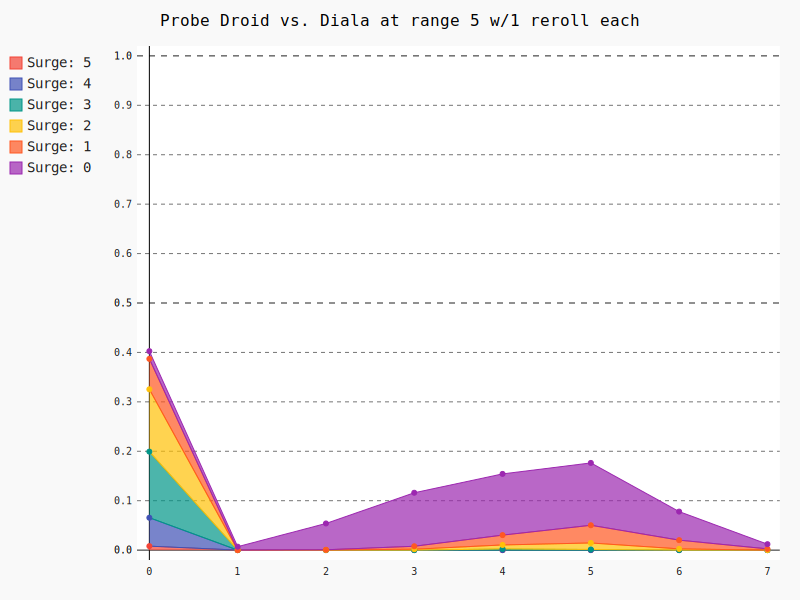

In [17]:
render_vs(EPB, DIALA, 5, 1, 1, 'Probe Droid vs. Diala at range 5 w/1 reroll each')

Average dmg, srg: 3.416666666666667, 0.763888888888889


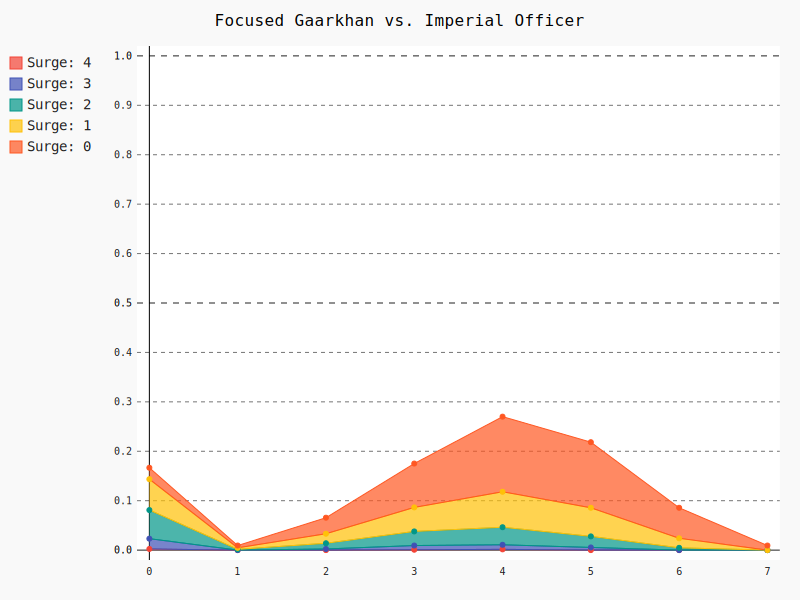

In [18]:
render_vs(focus_char(GAARKHAN), OFC, 0, 0, 0, 'Focused Gaarkhan vs. Imperial Officer')

Average dmg, srg: 3.166666666666667, 0.16666666666666666


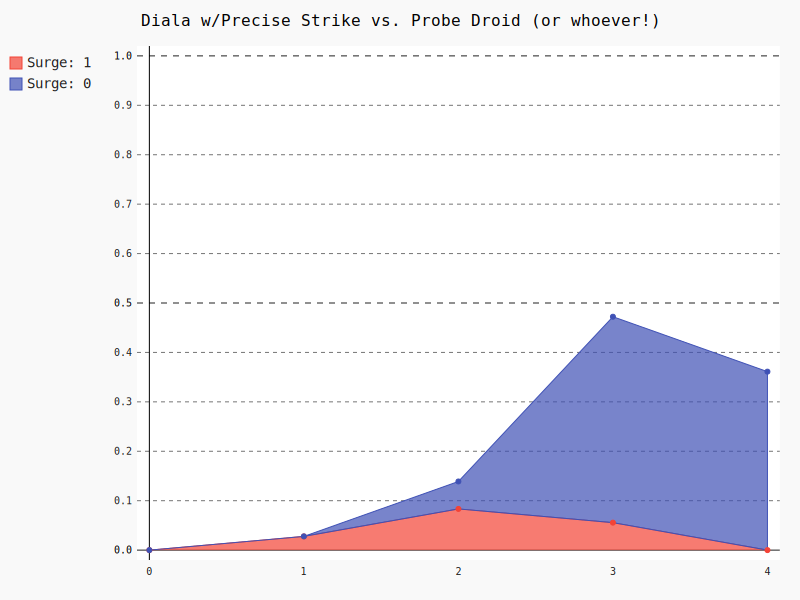

In [19]:
render_vs(DIALA, strip_def_die_char(EPB), 0, 0, 0, 'Diala w/Precise Strike vs. Probe Droid (or whoever!)')

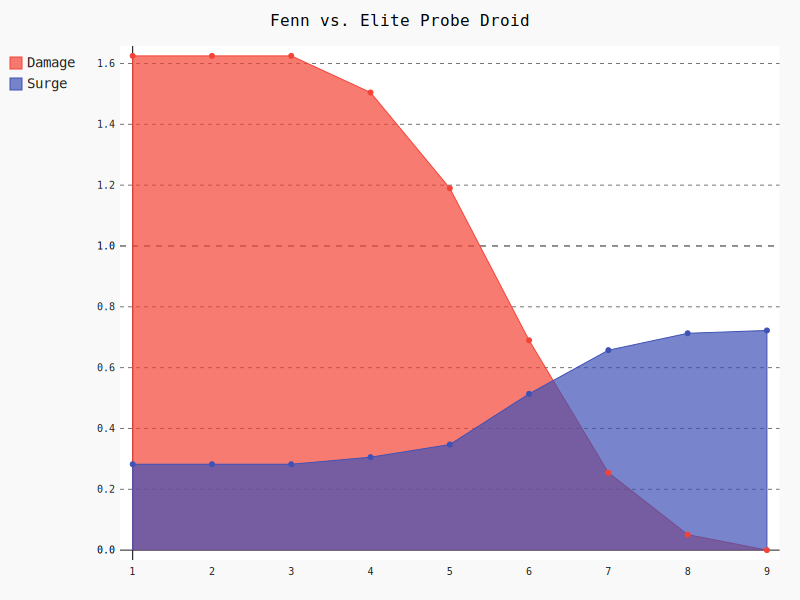

In [20]:
render_range(FENN, EPB, range(1,10), 0, 0, 'Fenn vs. Elite Probe Droid')

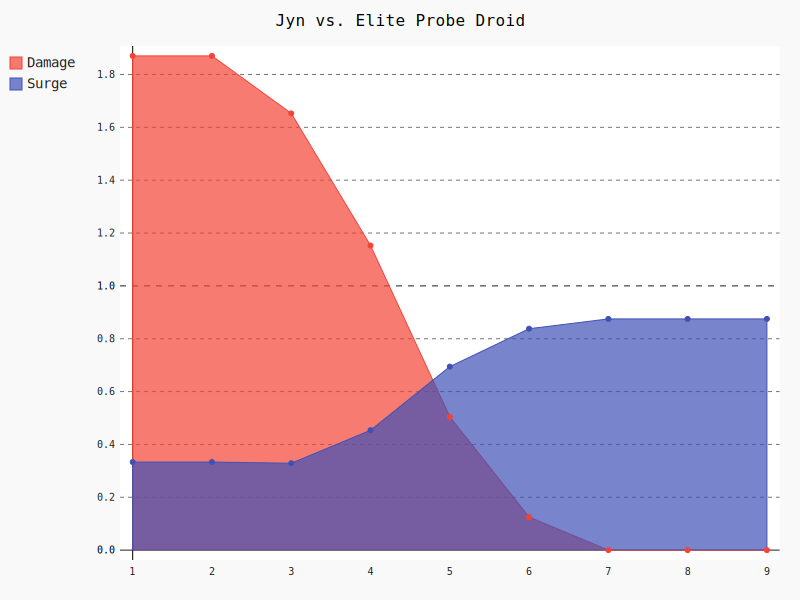

In [21]:
render_range(JYN, EPB, range(1,10), 0, 0, 'Jyn vs. Elite Probe Droid')

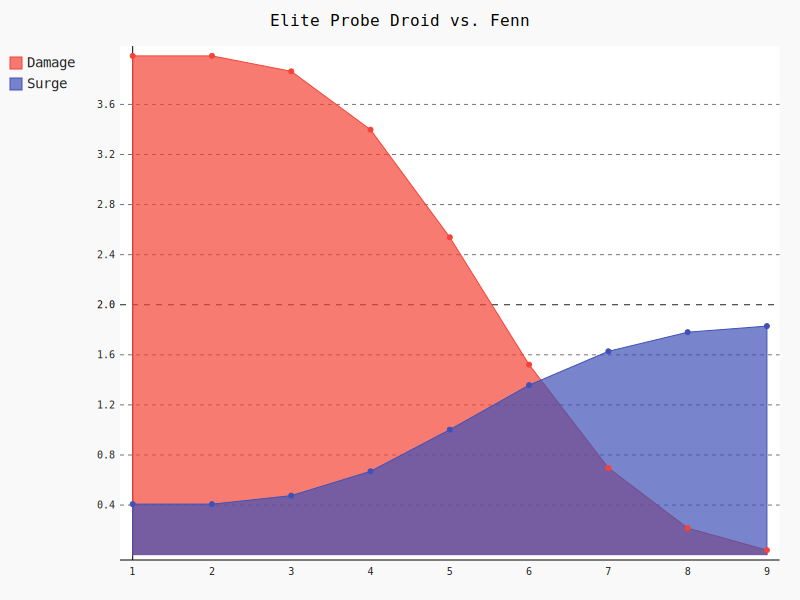

In [22]:
render_range(EPB, FENN, range(1,10), 0, 0, 'Elite Probe Droid vs. Fenn')

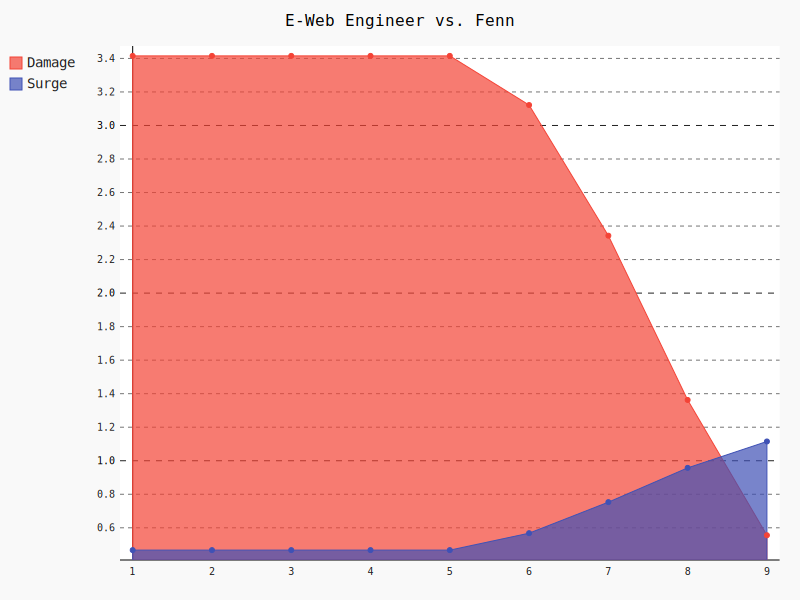

In [23]:
render_range(EWB, FENN, range(1,10), 0, 0, 'E-Web Engineer vs. Fenn')

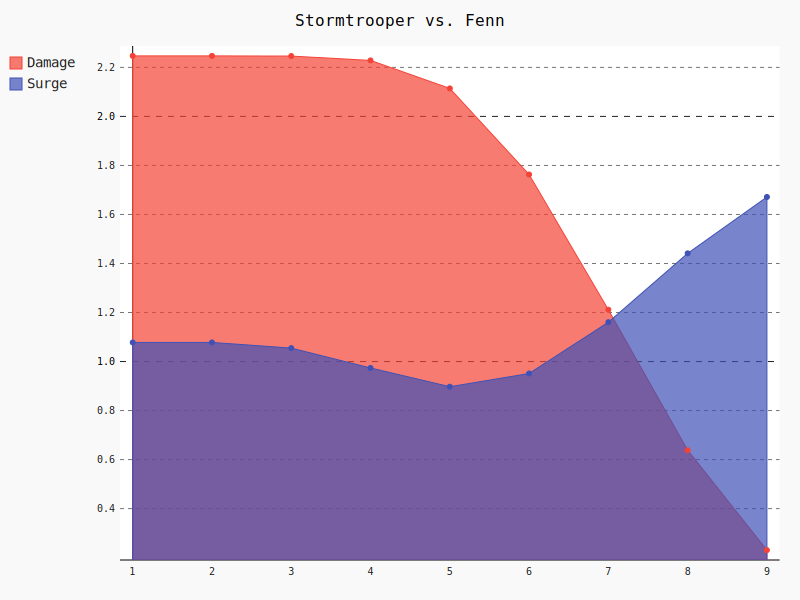

In [24]:
render_range(TRP, FENN, range(1,10), 0, 0, 'Stormtrooper vs. Fenn')

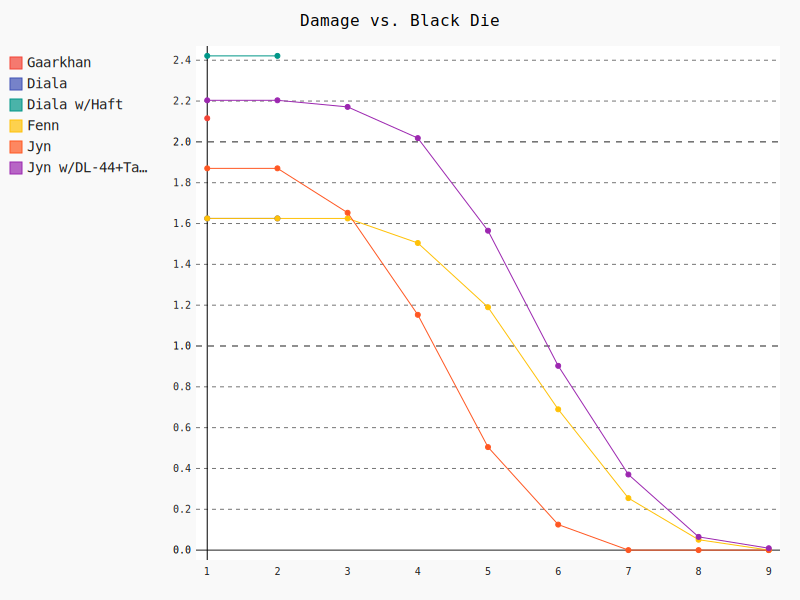

In [25]:
render_comparison_vs([('Gaarkhan', GAARKHAN, 0)], [('Diala',DIALA, 0), ('Diala w/Haft', DIALA_HAFT, 0)], [('Fenn', FENN, 0), ('Jyn', JYN, 0), ('Jyn w/DL-44+Tact', JYN_W_DL_44, 0)], ('Black Die', EPB, 0), range(1,10))

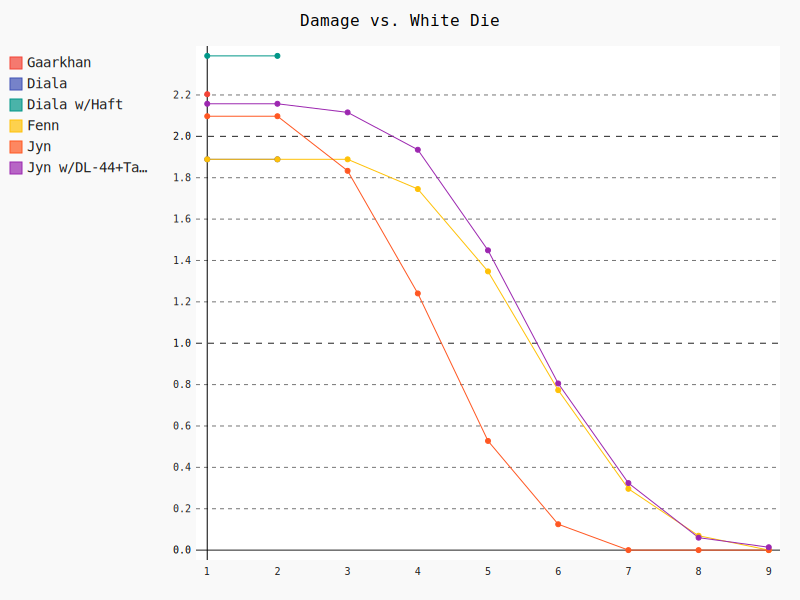

In [26]:
render_comparison_vs([('Gaarkhan', GAARKHAN, 0)], [('Diala',DIALA, 0), ('Diala w/Haft', DIALA_HAFT, 0)], [('Fenn', FENN, 0), ('Jyn', JYN, 0), ('Jyn w/DL-44+Tact', JYN_W_DL_44, 0)], ('White Die', OFC, 0), range(1,10))

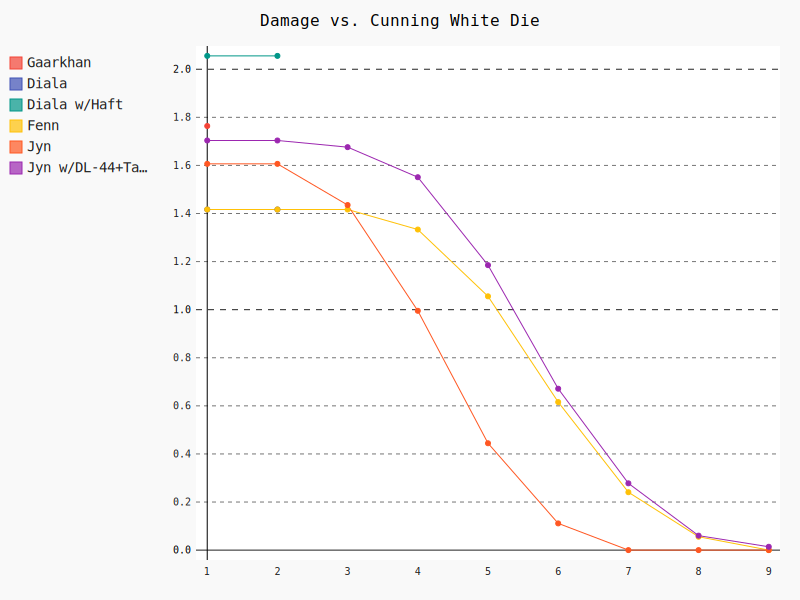

In [27]:
render_comparison_vs([('Gaarkhan', GAARKHAN, 0)], [('Diala',DIALA, 0), ('Diala w/Haft', DIALA_HAFT, 0)], [('Fenn', FENN, 0), ('Jyn', JYN, 0), ('Jyn w/DL-44+Tact', JYN_W_DL_44, 0)], ('Cunning White Die', NEX, 0), range(1,10))

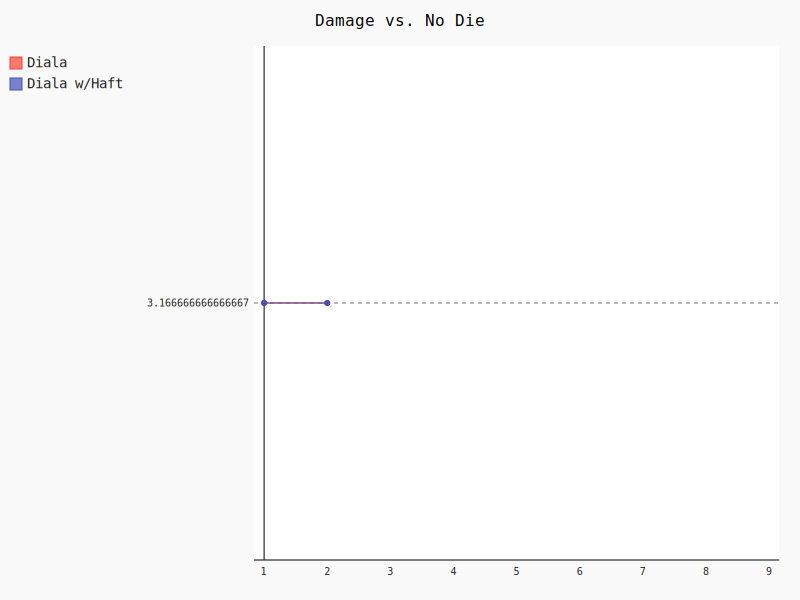

In [28]:
render_comparison_vs([], [('Diala',DIALA, 0), ('Diala w/Haft', DIALA_HAFT, 0)], [], ('No Die', [[],[],[],[]], 0), range(1,10))